# Data Science Capstone  
## Analyzing Gaming Addiction Trends and Player Engagement


In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as stats
import time
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

The `games_data` and `users_data` datasets were extracted from the **Steam Web API**, specifically using the **ISteamApps/GetAppList** and **IPlayerService/GetOwnedGames** endpoints.  

- **`steam_game_data.csv`** : This dataset contains detailed information about 91,690 games, including metadata such as the game title, developer, publisher, genre, release date, supported platforms, multiplayer support, graphics quality, story depth, and metrics like review scores and player engagement statistics.  

- **`user_playtime_data.csv`** : This dataset consists of 66,187 player-specific data, capturing metrics like total playtime, recent playtime, and game ownership information. Each user (`user_id`) can have multiple games (`game_id`) associated with their account.  

Let's load these datasets:  

##  `games_data`

In [2]:
games_data = pd.read_csv("../data/steam_game_data.csv")
users_data = pd.read_csv("../data/user_playtime_data.csv")
reviews_data = pd.read_csv("../data/reviews.csv")

In [3]:
# Let's look at the first 5 elements of the games_data
games_data.head()

,game_id,title,developer,publisher,genre,release_date,platforms,multiplayer_support,graphics_quality,story_depth,DLC_count,max_concurrent_players,average_review_score,number_of_reviews
0,40960,Stronghold 2: Steam Edition,FireFly Studios,FireFly Studios,"Simulation, Strategy",NaN,windows,True,Standard,Light,0,4366,0,4366
1,360450,Kiai Resonance,Absorb Reality,Flying Interactive,"Action, Indie, Simulation","Apr 23, 2015",windows,True,Standard,Light,0,154,0,154
2,237570,Penny Arcade's On the Rain-Slick Precipice of ...,Zeboyd Games,"Penny Arcade, Inc.","Indie, RPG",NaN,windows,False,Standard,Light,0,308,0,308
3,1294340,Wonhon: A Vengeful Spirit,BUSAN SANAI GAMES,SuperGG.com,"Action, Adventure, Indie, Strategy","Jul 15, 2021",windows,False,Standard,Light,0,0,0,0
4,3416070,Ropuka's Idle Island,"Moczan, Little Chmura, Begoña Pereda",Moczan,"Casual, Indie, Simulation","Jan 29, 2025",windows,False,Standard,Light,0,1086,0,1086


In [4]:
games_data.count()

game_id                   91690
title                     91669
developer                 91682
publisher                 91612
genre                     82724
release_date              90760
platforms                 91690
multiplayer_support       91690
graphics_quality          91690
story_depth               91690
DLC_count                 91690
max_concurrent_players    91690
average_review_score      91690
number_of_reviews         91690
dtype: int64

We can observe that most columns in the `games_data` dataset have 23,132 entries, with a few exceptions like `title`, `developer`, `publisher`, `genre`, and `release_date`, suggesting potential missing values.


In [5]:
games_data.shape

(91690, 14)

In [6]:
games_data.dtypes

game_id                    int64
title                     object
developer                 object
publisher                 object
genre                     object
release_date              object
platforms                 object
multiplayer_support         bool
graphics_quality          object
story_depth               object
DLC_count                  int64
max_concurrent_players     int64
average_review_score       int64
number_of_reviews          int64
dtype: object

Most of the data in the `games_data` dataset are of the `object` type, with numerical metrics stored as `int64` and `multiplayer_support` as a boolean (`bool`).


In [7]:
#let's look for the missing values

games_missing_values = games_data.isnull().sum()
games_missing_values

game_id                      0
title                       21
developer                    8
publisher                   78
genre                     8966
release_date               930
platforms                    0
multiplayer_support          0
graphics_quality             0
story_depth                  0
DLC_count                    0
max_concurrent_players       0
average_review_score         0
number_of_reviews            0
dtype: int64

### Let's remove those missing values:

In [8]:
# Removing rows with any missing values
games_data.dropna(inplace=True)

In [9]:
games_data.shape

(82269, 14)

After removing missing values, the `games_data` dataset is reduced to **18,479 rows** across **16 columns**,

In [10]:
games_data.count()

game_id                   82269
title                     82269
developer                 82269
publisher                 82269
genre                     82269
release_date              82269
platforms                 82269
multiplayer_support       82269
graphics_quality          82269
story_depth               82269
DLC_count                 82269
max_concurrent_players    82269
average_review_score      82269
number_of_reviews         82269
dtype: int64

In [11]:

# Attemptting to parse the dates with possible date formats : 
# Possible formats known from: https://steamcommunity.com/sharedfiles/filedetails/?id=2554483179#:~:text=Date%20part%20order%20can%20be,format%20will%20be%20applied%20immediately.

valid_dates_format1 = pd.to_datetime(games_data['release_date'], format='%d %b, %Y', errors='coerce')
valid_dates_format2 = pd.to_datetime(games_data['release_date'], format='%b %d, %Y', errors='coerce')
valid_dates_format3 = pd.to_datetime(games_data['release_date'], format='%d %b %Y', errors='coerce')

# Identify rows that do not match either of the formats
invalid_dates = games_data[(valid_dates_format1.isna()) & (valid_dates_format2.isna()) & (valid_dates_format3.isna())]

# Display rows with invalid date formats
print("Rows with invalid date formats:")
print(invalid_dates[['release_date']])

print("There are a total of ", len(invalid_dates), "invalid dates")


Rows with invalid date formats:
          release_date
116       9. März 2023
132      28. Aug. 2020
215    To be announced
218    To be announced
541        Coming soon
...                ...
91654      Coming soon
91660      Coming soon
91672      Coming soon
91674      Coming soon
91687      Coming soon

[8021 rows x 1 columns]
There are a total of  8021 invalid dates


We can observe that for some games that have not been released yet, the `release_date` column contains values like **Q2 2025**, **To be announced**, and **Coming soon**, along with some dates in different language formats, so let's remove them since we won't be needing those for our analysis.


In [12]:
# let's remove those invalid dates
invalid_dates_list = invalid_dates['release_date'].tolist()
games_data = games_data[~games_data['release_date'].isin(invalid_dates_list)]

In [13]:
games_data.count()

game_id                   74248
title                     74248
developer                 74248
publisher                 74248
genre                     74248
release_date              74248
platforms                 74248
multiplayer_support       74248
graphics_quality          74248
story_depth               74248
DLC_count                 74248
max_concurrent_players    74248
average_review_score      74248
number_of_reviews         74248
dtype: int64

After removing those invalid dates, the `games_data` dataset now contains **74,248** entries across all columns. We now have only relevant release dates are included for analysis.

Now, let's make the date format consistent in all rows


In [14]:
# Combining all parsed dates
games_data['release_date'] = valid_dates_format1.fillna(valid_dates_format2).fillna(valid_dates_format3)

# Convert dates to 'YYYY-MM-DD' format for consistency only
games_data['release_date'] = games_data['release_date'].dt.strftime('%Y-%m-%d')

# `users_data`

In [15]:
# Let's look at the first 5 elements of the users_data
users_data.head()

,user_id,game_count,appid,name,playtime_forever,playtime_2weeks
0,76561198450606184,24,500,Left 4 Dead,0,0
1,76561198450606184,24,550,Left 4 Dead 2,0,0
2,76561198450606184,24,41070,Serious Sam 3: BFE,56,0
3,76561198450606184,24,564310,Serious Sam Fusion 2017 (beta),0,0
4,76561198450606184,24,203160,Tomb Raider,0,0


In [16]:
users_data.count()

user_id             325941
game_count          325941
appid               325941
name                325941
playtime_forever    325941
playtime_2weeks     325941
dtype: int64

The `users_data` dataset contains **326,768** entries across all columns.

In [17]:
users_data.shape

(325941, 6)

In [18]:
users_data.dtypes

user_id              int64
game_count           int64
appid                int64
name                object
playtime_forever     int64
playtime_2weeks      int64
dtype: object

Most of the data in the `users_data` dataset are of the `int64` type, with only the `name` column being of the `object` type. We have numerical data for user gaming behavior analysis.


In [19]:
# let's look for missing values
users_missing_values = users_data.isnull().sum()
users_missing_values

user_id             0
game_count          0
appid               0
name                0
playtime_forever    0
playtime_2weeks     0
dtype: int64

No mising values

In [20]:
# Rename the column from 'appid' to 'game_id'
users_data.rename(columns={'appid': 'game_id'}, inplace=True)

Since one user can have multiple data entries, the `user_id` column can be repeated for the same person, so let's check the number of unique users and unique games in the `users_data` dataset.


In [21]:
print("There are ", len(users_data['user_id'].unique()) , " unique users in our user dataset.")

There are  99008  unique users in our user dataset.


In [22]:
print("There are ", len(users_data['game_id'].unique()) , " unique games in our user dataset.")

There are  17084  unique games in our user dataset.


In [23]:
# if they played RECENTLY, playtime_2weeks will be greater than 0

# Filter players with recent playtime (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played recently: {unique_recent_players_count}")


Number of unique users who played recently: 35950


In [24]:
# If they are genuine players, `playtime_forever` will be greater than 0.
# I am considering the fact that some users might just create an account and never actually play.


# Filter players with at least some playtime (playtime_forever > 0)
recent_players = users_data[users_data['playtime_forever'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played at least a min: {unique_recent_players_count}")


Number of unique users who played at least a min: 98578


In [25]:
# let's add avg_playtime coloumn - for viz
users_data['avg_playtime'] = users_data['playtime_2weeks'] / 14

In [26]:
# Convert playtime from minutes to hours
users_data['playtime_2weeks'] = users_data['playtime_2weeks'] / 60
users_data['playtime_forever'] = users_data['playtime_forever'] / 60

Let's do some visualizations

In [27]:


# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import missingno as msno



# # Merging user_data with games_data on game_id
# merged_data = users_data.merge(games_data, on='game_id', how='left')
# merged_data.dropna(inplace=True)

# df = merged_data




# # Identify numerical columns
# num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# # Plot histograms and KDE for numerical features
# for col in num_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(df[col].dropna(), kde=True)
#     plt.title(f"Distribution of {col}")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.show()


# # Outlier Detection via Boxplots

# # %% [code]
# for col in num_cols:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=df[col].dropna())
#     plt.title(f"Boxplot of {col}")
#     plt.xlabel(col)
#     plt.show()


# # Identify categorical columns
# cat_cols = df.select_dtypes(include=['object', 'category']).columns

# # Plot count plots for each categorical feature
# for col in cat_cols:
#     plt.figure(figsize=(12, 6))
#     sns.countplot(y=col, data=df, order=df[col].value_counts().index)
#     plt.title(f"Count Plot for {col}")
#     plt.xlabel("Count")
#     plt.ylabel(col)
#     plt.show()


# # Compute correlation matrix for numerical features
# corr = df[num_cols].corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
# plt.title("Correlation Heatmap")
# plt.show()


# # Pair Plot for Numerical Features
# # Note: Pair plots can be heavy for large datasets. Consider using a sample if needed.

# # %% [code]
# sns.pairplot(df[num_cols].dropna())
# plt.suptitle("Pair Plot of Numerical Features", y=1.02)
# plt.show()


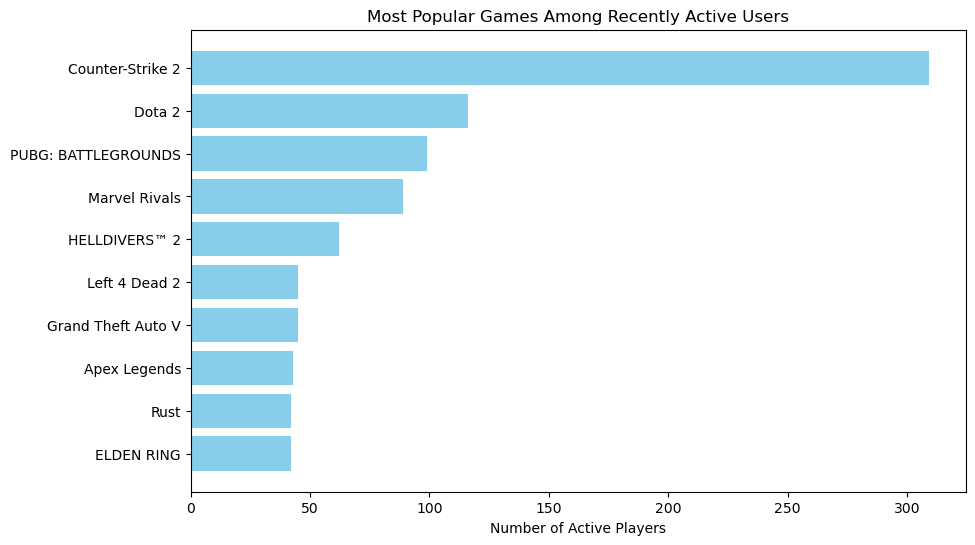

,game_id,count
0,730,309
1,570,116
2,578080,99
3,2767030,89
4,553850,62
5,271590,55
6,1172470,46
7,550,45
8,252490,42
9,1245620,42


In [28]:
# Most Popular Games Among Recently Active Users (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]
most_popular_games = recent_players['name'].value_counts().head(10).reset_index()
most_popular_games.columns = ['Game', 'Active Players']



# Visualization: Most Popular Games
plt.figure(figsize=(10, 6))
plt.barh(most_popular_games['Game'], most_popular_games['Active Players'], color='skyblue')
plt.xlabel('Number of Active Players')
plt.title('Most Popular Games Among Recently Active Users')
plt.gca().invert_yaxis()
plt.show()

most_popular_games =recent_players['game_id'].value_counts().head(10).reset_index()
most_popular_games

The bar chart shows **Counter-Strike 2** leading by a significant margin, followed by **Dota 2** and **PUBG: BATTLEGROUNDS**.

Interestingly, while **Counter-Strike 2**, **Dota 2**, and **PUBG: BATTLEGROUNDS** are well-known for maintaining high player counts globally, title like **Marvel Rivals** attract players with their casual and practical uses.


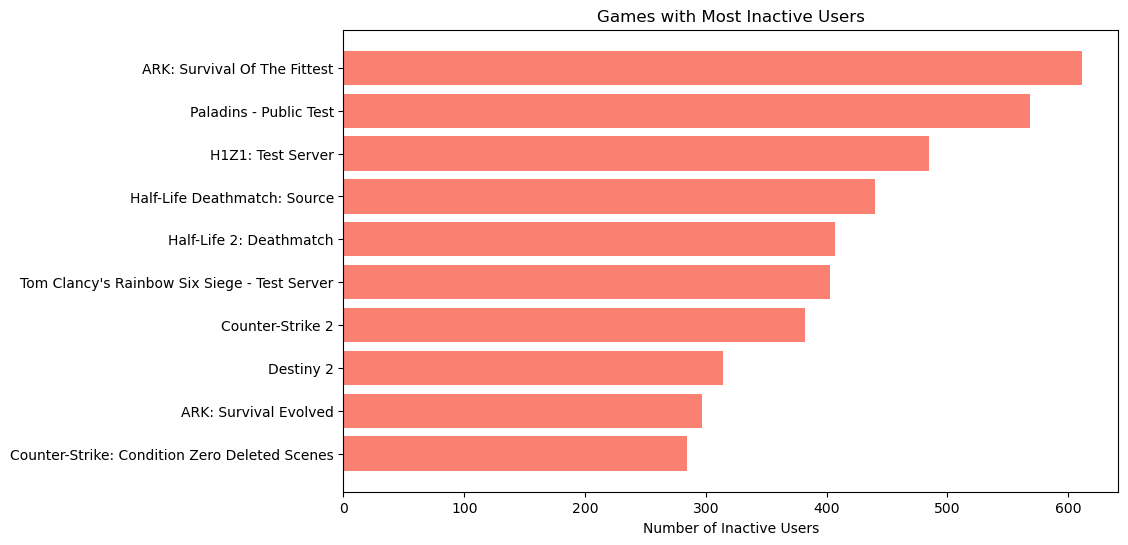

In [29]:
# Inactive Users with Zero Playtime and Their Associated Games
inactive_users = users_data[(users_data['playtime_forever'] == 0) & (users_data['playtime_2weeks'] == 0)]
inactive_user_games = inactive_users['name'].value_counts().head(10).reset_index()
inactive_user_games.columns = ['Game', 'Inactive User Count']

plt.figure(figsize=(10, 6))
plt.barh(inactive_user_games['Game'], inactive_user_games['Inactive User Count'], color='salmon')
plt.xlabel('Number of Inactive Users')
plt.title('Games with Most Inactive Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **ARK: Survival Of The Fittest**, **Paladins - Public Test**, and **H1Z1: Test Server** leading the list.  

Interestingly, many of the top inactive games are **test servers** or **public test versions**, suggesting that players might try these versions briefly without continuing to play regularly.  

Let's also note here that even popular titles like **Counter-Strike 2** and **Destiny 2** appear on this list. This indicates that not all players remain engaged over time.


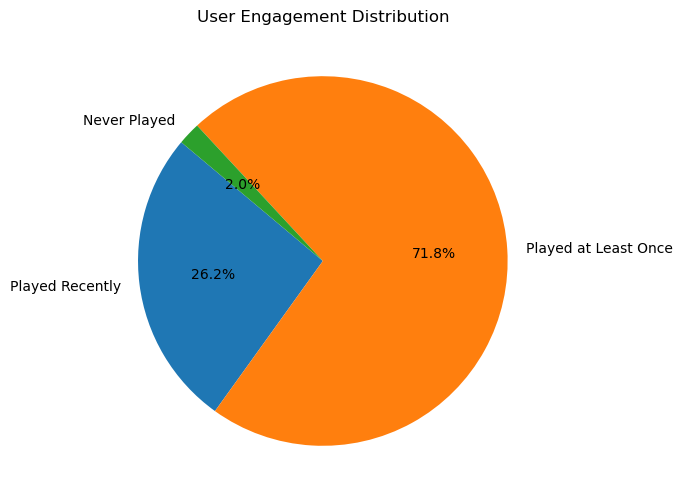

In [30]:
# lets see how many played recently, played at least once and never played at all
engagement_labels = ['Played Recently', 'Played at Least Once', 'Never Played']
engagement_counts = [
    users_data[users_data['playtime_2weeks'] > 0]['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] > 0]['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] == 0]['user_id'].nunique()
]

plt.figure(figsize=(6, 6))
plt.pie(engagement_counts, labels=engagement_labels, autopct='%1.1f%%', startangle=140)
plt.title('User Engagement Distribution')
plt.show()

In [31]:
print(len(users_data[users_data['playtime_forever'] > 0]))
print(len(users_data[users_data['playtime_forever'] == 0]))
print(len(users_data[users_data['playtime_2weeks'] > 0]))

240418
85523
40344


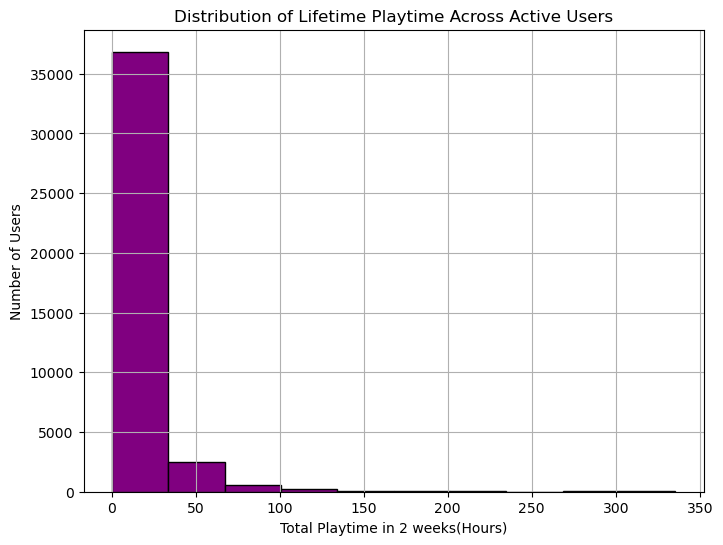

In [32]:
# let's observe the distribution of lifetime Playtime Across Active Users

# Filter only users with playtime_forever > 0
active_users = users_data[users_data['playtime_2weeks'] > 0]


# Create a histogram for active users
plt.figure(figsize=(8, 6))
plt.hist(active_users['playtime_2weeks'], bins=10, color='purple', edgecolor='black')
plt.xlabel('Total Playtime in 2 weeks(Hours)')
plt.ylabel('Number of Users')
plt.title('Distribution of Lifetime Playtime Across Active Users')
plt.grid(True)
plt.show()


According to the histogram, the majority of users have a **low total playtime**, mainly under **50 hours**.  

The **right-skewed distribution** indicates that while most players spend limited time in games, a small number of users have **extremely high playtimes**, potentially pointing to **high engagement** or **gaming addiction**.

We will later explore these **outliers** to understand what drives such high playtime and if specific games contribute to this behavior.


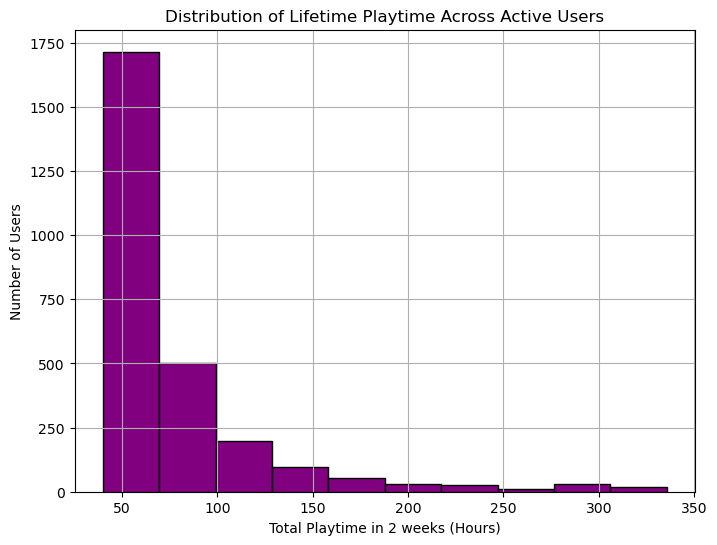

In [33]:
# let's observe the distribution of lifetime Playtime Across Active Users

# Filter only users with playtime_forever > 40
active_users = users_data[users_data['playtime_2weeks'] > 40]


# Create a histogram for active users
plt.figure(figsize=(8, 6))
plt.hist(active_users['playtime_2weeks'], bins=10, color='purple', edgecolor='black')
plt.xlabel('Total Playtime in 2 weeks (Hours)')
plt.ylabel('Number of Users')
plt.title('Distribution of Lifetime Playtime Across Active Users')
plt.grid(True)
plt.show()


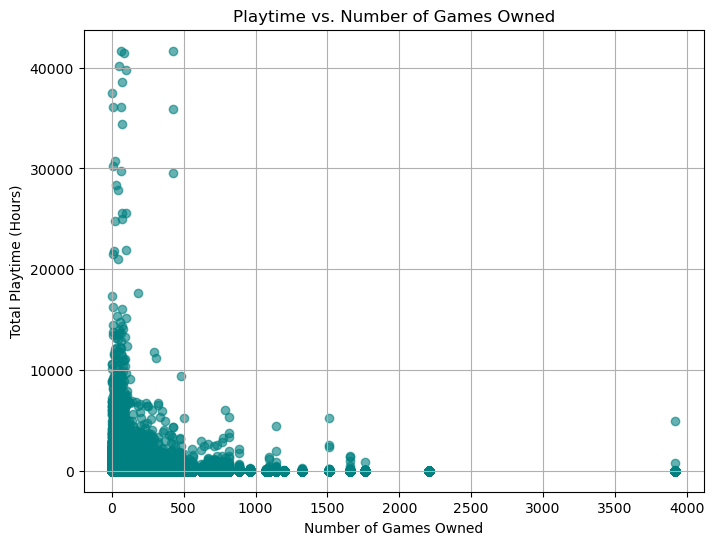

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(users_data['game_count'], users_data['playtime_forever'], alpha=0.6, color='teal')
plt.xlabel('Number of Games Owned')
plt.ylabel('Total Playtime (Hours)')
plt.title('Playtime vs. Number of Games Owned')
plt.grid(True)
plt.show()


The scatter plot shows most users clustering around **low playtime** and **fewer owned games**.  

While a few users own **hundreds to over a thousand games**, their total playtime does not always scale up, suggesting that **game collectors**(those who own lots of games) may not necessarily be **active players**.  

Again, we can see few **outliers** with **extremely high playtime**, indicating possible **addictive behavior**, regardless of the total number of games owned.


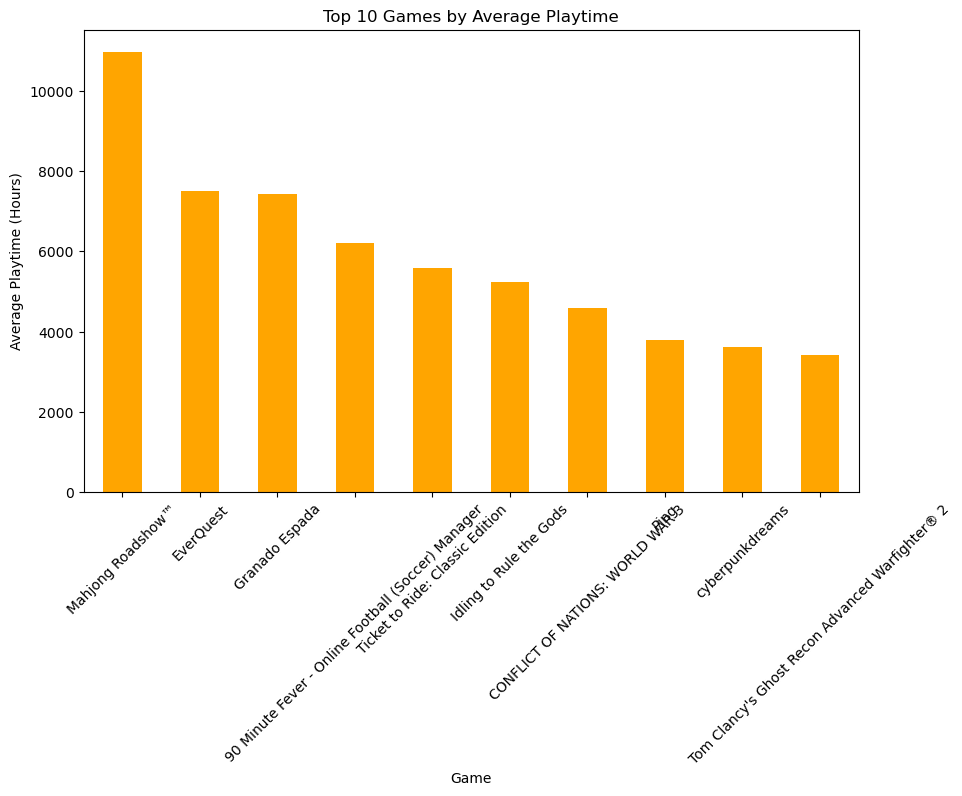

In [35]:
average_playtime_per_game = users_data.groupby('name')['playtime_forever'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
average_playtime_per_game.plot(kind='bar', color='orange')
plt.xlabel('Game')
plt.ylabel('Average Playtime (Hours)')
plt.title('Top 10 Games by Average Playtime')
plt.xticks(rotation=45)
plt.show()


The bar chart shows **Mahjong Roadshow** leading by a significant margin, followed by **Idling to Rule the Gods** and **GameMaker: Studio**.  

Most of these top games with high average playtime are **idle games**, which often encourage **longer running sessions** without active engagement.  

But we can see **Dota 2**, which interestingly is the only **competitive multiplayer game** in this list, showing that while **idle games** dominate average playtime, some traditional games also maintain **high engagement** among their player base.


In [36]:
#Dherai game khelne haru 20 hours
high_playtime_count = (users_data['playtime_2weeks'] / 2 > 20).sum()
high_playtime_count

2680

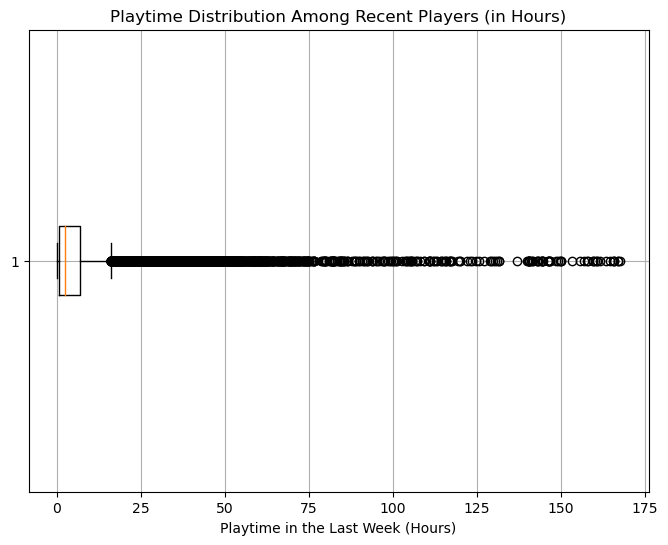

count    40344.000000
mean         6.109860
std         11.462428
min          0.008333
25%          0.625000
50%          2.433333
75%          6.841667
max        167.766667
Name: playtime_hours, dtype: float64

In [37]:

recent_players = users_data[users_data['playtime_2weeks'] > 0]
# let's see a box plot
recent_players['playtime_hours'] = recent_players['playtime_2weeks'] / 2
# 
#recent_players = recent_players[recent_players['playtime_hours'] <= 50]

plt.figure(figsize=(8, 6))
plt.boxplot(recent_players['playtime_hours'], vert=False)
plt.xlabel('Playtime in the Last Week (Hours)')
plt.title('Playtime Distribution Among Recent Players (in Hours)')
plt.grid(True)
plt.show()

recent_players.describe()['playtime_hours']

## Q1. How much time are people spending on gaming per week, and what does it reveal about gaming addiction trends?

In [38]:
# let's first filter only active users
active_users = users_data[users_data['playtime_2weeks'] > 0]

# calculate weekly playtime (in hours) for those active uses
active_users['weekly_playtime_hours'] = (active_users['playtime_2weeks'] / 2)

# Descriptive statistics of weekly playtime 
active_playtime_stats = active_users['weekly_playtime_hours'].describe()
print("Weekly Playtime Statistics for Active Users (in Hours):")
print(active_playtime_stats)


Weekly Playtime Statistics for Active Users (in Hours):
count    40344.000000
mean         6.109860
std         11.462428
min          0.008333
25%          0.625000
50%          2.433333
75%          6.841667
max        167.766667
Name: weekly_playtime_hours, dtype: float64


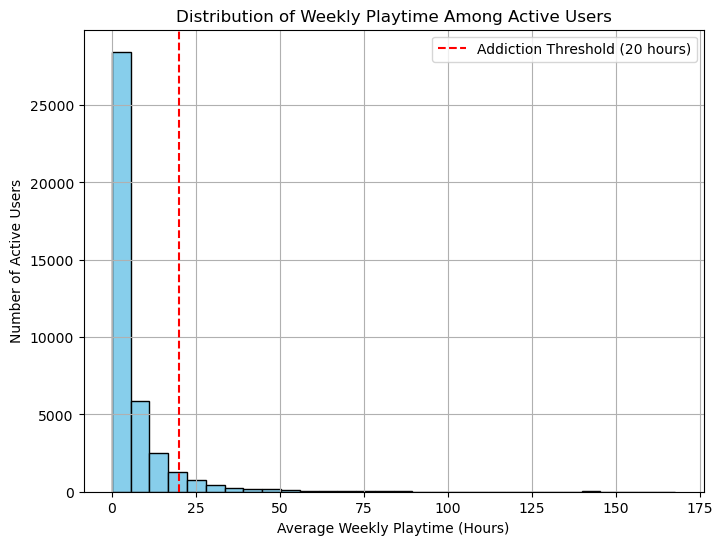

In [39]:
# visualization the  distribution of weekly playtime
plt.figure(figsize=(8, 6))
plt.hist(active_users['weekly_playtime_hours'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=20, color='red', linestyle='--', label='Addiction Threshold (20 hours)')
plt.xlabel('Average Weekly Playtime (Hours)')
plt.ylabel('Number of Active Users')
plt.title('Distribution of Weekly Playtime Among Active Users')
plt.legend()
plt.grid(True)
plt.show()


Active User Distribution by Playtime Category:
playtime_category
Casual Gamer           30438
Moderate Gamer          7226
Potential Addiction     2680
Name: count, dtype: int64


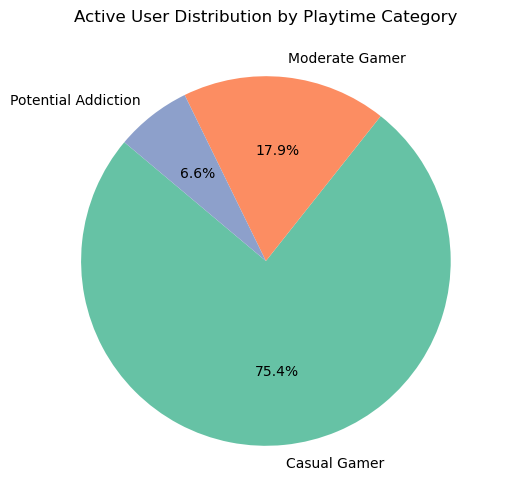

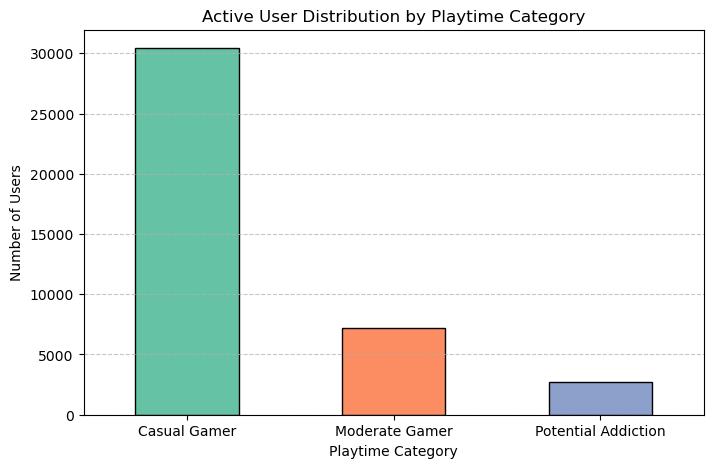

In [40]:

# Lets also cateogrize active users based on weekly playtime
def categorize_playtime(hours):
    if hours < 7:
        return 'Casual Gamer'
    elif hours < 20:
        return 'Moderate Gamer'
    else:
        return 'Potential Addiction'

active_users['playtime_category'] = active_users['weekly_playtime_hours'].apply(categorize_playtime)

# total active users in each category
active_category_counts = active_users['playtime_category'].value_counts()
print("\nActive User Distribution by Playtime Category:")
print(active_category_counts)

plt.figure(figsize=(6, 6))
plt.pie(active_category_counts, labels=active_category_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Active User Distribution by Playtime Category')
plt.show()

plt.figure(figsize=(8, 5))
active_category_counts.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')

# Labels and title
plt.xlabel('Playtime Category')
plt.ylabel('Number of Users')
plt.title('Active User Distribution by Playtime Category')
plt.xticks(rotation=0)  # Keep category labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



- **Majority of Active Users:** 75.4% are **Casual Gamers**, playing **less than 7 hours per week**.  
- **Moderate Gamers:** 17.9% play **between 7 to 20 hours per week**, showing **healthy engagement**.  
- **Potential Addiction:** 6.6% of active users exceed **20 hours per week**, indicating a **possible risk of gaming addiction**.  


With only **6.6%** of active users in the '**Potential Addiction**' category, **gaming addiction** does not seem to be a **significant trend** in the dataset.  

The overwhelming majority of active users are **casual gamers**. This suggests that **most people use gaming as a light, recreational activity**. And also may indicate that **games are engaging enough for short sessions but not overly addictive**.  


The **17.9%** of **moderate gamers** play **7 to 20 hours per week**, showing a **healthy interest** in gaming.


The **histogram** shows a **long tail**, with a **few users playing well beyond 40 hours per week**.


## Q2. Which game design elements—such as microtransactions, progression systems, and multiplayer vs. single-player structures—are most associated with prolonged playtime and potential addiction? 

In [41]:
# Merging user_data with games_data on game_id
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)


merged_data = merged_data[merged_data['playtime_2weeks'] > 0]


merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


merged_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40480 entries, 13 to 327753
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 40480 non-null  int64  
 1   game_count              40480 non-null  int64  
 2   game_id                 40480 non-null  int64  
 3   name                    40480 non-null  object 
 4   playtime_forever        40480 non-null  float64
 5   playtime_2weeks         40480 non-null  float64
 6   avg_playtime            40480 non-null  float64
 7   title                   40480 non-null  object 
 8   developer               40480 non-null  object 
 9   publisher               40480 non-null  object 
 10  genre                   40480 non-null  object 
 11  release_date            40480 non-null  object 
 12  platforms               40480 non-null  object 
 13  multiplayer_support     40480 non-null  int64  
 14  graphics_quality        40480 non-null  o

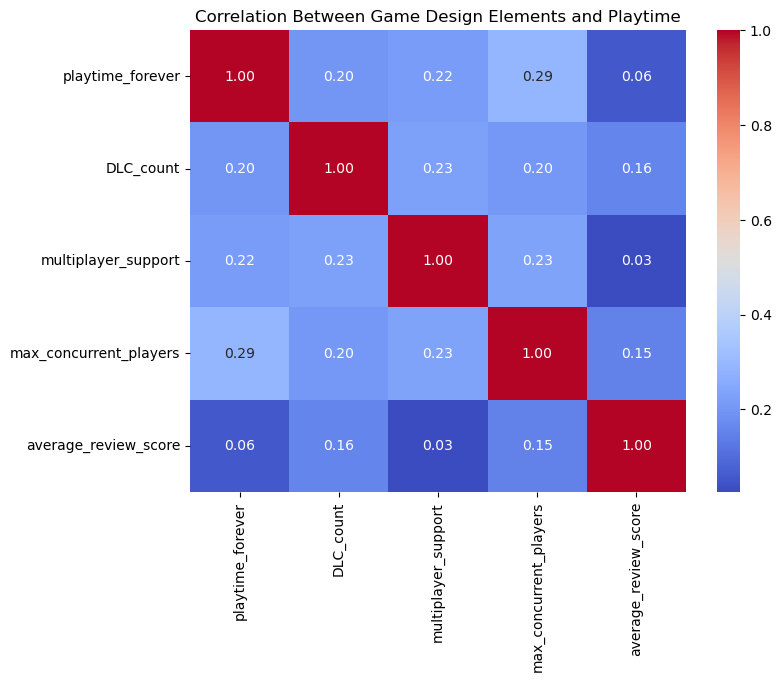

In [42]:
# Merging user_data with games_data on game_id
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)


merged_data = merged_data[merged_data['playtime_2weeks'] > 0]


merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


# game design elements for analysis
design_elements = ["DLC_count", "multiplayer_support", "max_concurrent_players", "average_review_score"]


merged_data['playtime_forever'] = np.log1p(merged_data['playtime_forever'])
merged_data['DLC_count'] = np.log1p(merged_data['DLC_count'])
merged_data['max_concurrent_players'] = np.log1p(merged_data['max_concurrent_players'])
merged_data['average_review_score'] = np.log1p(merged_data['average_review_score'])
merged_data['playtime_2weeks'] = np.log1p(merged_data['playtime_2weeks'])

correlation_results = merged_data[["playtime_forever"] + design_elements].corr()


# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Game Design Elements and Playtime")
plt.show()



The heatmap shows that **multiplayer support (0.22), DLC count (0.20) and max concurrent players(0.29)** have the strongest positive correlations with playtime, suggesting that games with **multiplayer features and additional content tend to retain players longer**. 

The **average review score (0.03)** have weaker correlations, which implies that highly rated games may not always have the highest player engagement.


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = merged_data[["DLC_count", "multiplayer_support", "max_concurrent_players", "average_review_score"]]
y = merged_data["playtime_forever"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importances_df.sort_values(by='Importance', ascending=False, inplace=True)
importances_df


,Feature,Importance
2,max_concurrent_players,0.704844
0,DLC_count,0.131964
3,average_review_score,0.127709
1,multiplayer_support,0.035482


## Hypothesis Testing Analysis: Multiplayer Support and Gaming Addiction

In this analysis, we investigate the relationship between multiplayer support and gaming addiction, where addiction is defined as having more than 20 hours of playtime in a week.

#### Hypotheses

- **Null Hypothesis (H₀):**  
  There is no association between multiplayer support and addiction status. In other words, the proportion of addicted players (playtime_2weeks > 20) is the same regardless of whether a game has multiplayer support or not.

- **Alternative Hypothesis (H₁):**  
  There is an association between multiplayer support and addiction status. That is, the proportion of addicted players differs between games with and without multiplayer support.

#### Analysis



In [44]:
import pandas as pd
from scipy.stats import chi2_contingency

merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]
merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


df_filtered = merged_data[merged_data['playtime_2weeks'] > 0].copy()

# Create addicted column: 1 if playtime_2weeks > 20, else 0
df_filtered['addicted'] = (df_filtered['playtime_2weeks'] > 40).astype(int)

# Create contingency table between multiplayer_support and addicted status
contingency_table = pd.crosstab(df_filtered['multiplayer_support'], df_filtered['addicted'])

print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")


Contingency Table:
addicted                 0     1
multiplayer_support             
0                    20901  1229
1                    16897  1453

Chi-square Statistic: 90.2928
Degrees of Freedom: 1
P-value: 2.0539951084235806e-21


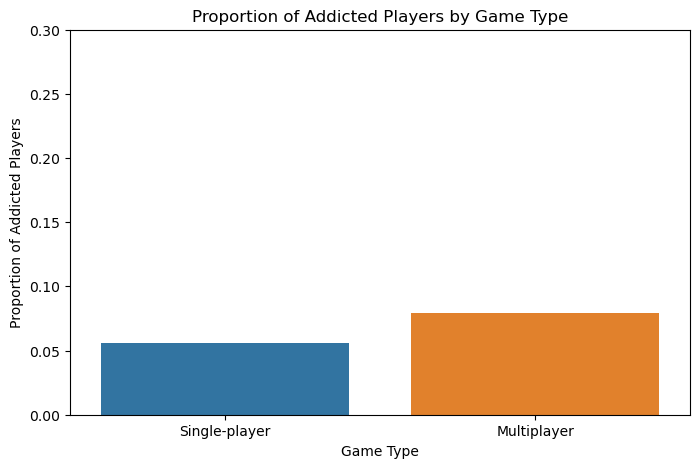

In [45]:
prop_df = df_filtered.groupby('multiplayer_support')['addicted'].mean().reset_index()
prop_df['Game Type'] = prop_df['multiplayer_support'].map({0: 'Single-player', 1: 'Multiplayer'})

plt.figure(figsize=(8, 5))
sns.barplot(x='Game Type', y='addicted', data=prop_df)
plt.ylabel("Proportion of Addicted Players")
plt.title("Proportion of Addicted Players by Game Type")

plt.ylim(0, 0.3) 
plt.show()

#### Conclusion

Since the p-value is extremely small (p < 0.05), we reject the null hypothesis. This indicates that there is a statistically significant association between multiplayer support and gaming addiction status. In summary, the data provide strong evidence that the proportion of players classified as addicted (based on playtime_2weeks > 20 hours) differs significantly between games with and without multiplayer support.

T-test Statistic: 19.17, P-value: 0.00000


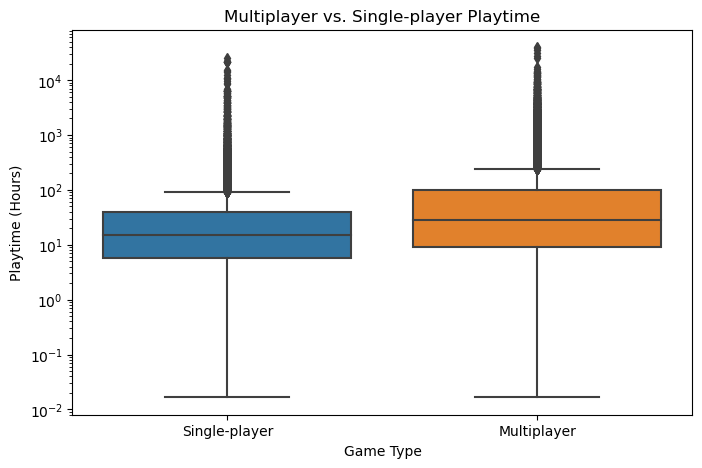

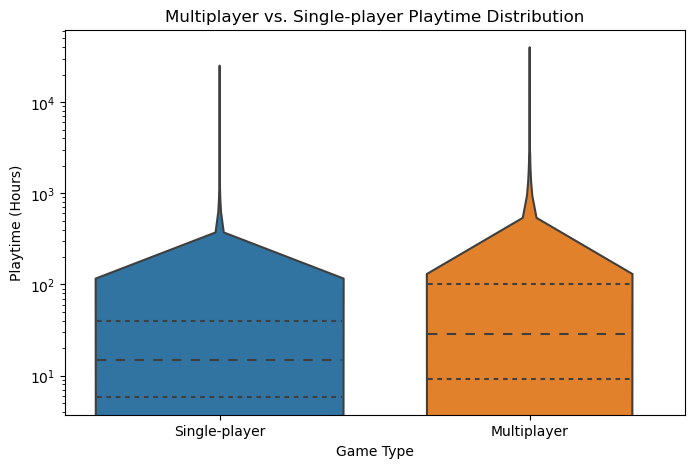

In [46]:

#  Multiplayer vs. Single-player Playtime
# T-test
multiplayer_playtime = merged_data[merged_data["multiplayer_support"] == 1]["playtime_forever"]
singleplayer_playtime = merged_data[merged_data["multiplayer_support"] == 0]["playtime_forever"]

t_stat, p_value = stats.ttest_ind(multiplayer_playtime, singleplayer_playtime, equal_var=False)
print(f"T-test Statistic: {t_stat:.2f}, P-value: {p_value:.5f}")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"])
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime")
plt.yscale("log")  # Adjust scale due to high variance
plt.show()

# violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"], inner="quartile")
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime Distribution")
plt.yscale("log")  # Log scale for better visibility
plt.show()


The violin plot shows that **multiplayer games have significantly higher playtime distributions compared to single-player games**, with a greater concentration of players spending **tens of thousands of hours** in multiplayer experiences.

The **wider upper distribution in multiplayer games** suggests that they encourage prolonged engagement more than single-player titles, likely due to **social interactions, competitive elements, and continuous content updates**.


               user_id  game_count  game_id                 name  \
13   76561198450606184          24   578080  PUBG: BATTLEGROUNDS   
346  76561198009377046         302   244850      Space Engineers   
415  76561198009377046         302  2507950          Delta Force   
509  76561198109099647          80   976310     Mortal Kombat 11   
516  76561198109099647          80  1172470         Apex Legends   

     playtime_forever  playtime_2weeks  avg_playtime                title  \
13         498.283333         0.633333      2.714286  PUBG: BATTLEGROUNDS   
346        307.800000       159.183333    682.214286      Space Engineers   
415         13.900000         0.066667      0.285714          Delta Force   
509          0.266667         0.266667      1.142857     Mortal Kombat 11   
516        600.300000        44.866667    192.285714        Apex Legends™   

                             developer  \
13                    PUBG Corporation   
346                Keen Software House   
41

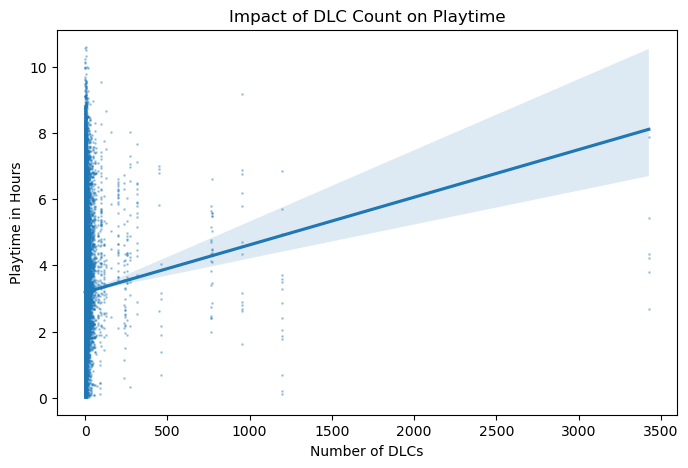

In [47]:
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]

merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)

print(merged_data.head())
# remove extreme outliers ( games with >10,000 hours)
filtered_data = merged_data

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=filtered_data["DLC_count"], 
            y=np.log1p(filtered_data["playtime_forever"]),  # Log transform playtime
             scatter_kws={"alpha": 0.3, "s": 1})

plt.xlabel("Number of DLCs")
plt.ylabel("Playtime in Hours")
plt.title("Impact of DLC Count on Playtime")
plt.show()


The regression plot suggests a **negative correlation** between DLC count and playtime, indicating that **games with more DLCs tend to have lower average playtime**. However, the small sample size and wide confidence interval suggest this trend may not be statistically significant.

This result contrasts with expectations, implying that additional content does not always drive long-term engagement. Other factors, such as **game quality, core mechanics, or monetization strategies**, may influence playtime more than DLC quantity.

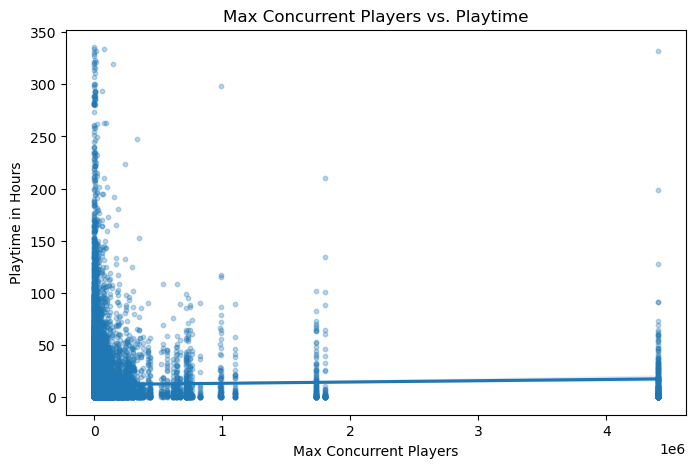

In [48]:
plt.figure(figsize=(8, 5))
sns.regplot(
    x=merged_data["max_concurrent_players"], 
    y=merged_data["playtime_2weeks"], 
    scatter_kws={'alpha': 0.3, 's': 10}  # Adjust 's' for smaller dots
)
plt.xlabel("Max Concurrent Players")
plt.ylabel("Playtime in Hours")
plt.title("Max Concurrent Players vs. Playtime")
plt.show()


The regression plot suggests a **weak positive correlation** between max concurrent players and playtime, indicating that **games with more concurrent players tend to have slightly longer average playtime**. However, the **broad confidence interval** highlights significant variability.

While more popular games may encourage extended engagement, **other factors such as game design, progression systems, and monetization models** likely play a more critical role in determining overall playtime.


In [49]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind


merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]

merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


# Assume df_filtered is defined as before with an 'addicted' column
df_filtered = merged_data[merged_data['playtime_2weeks'] > 0].copy()
df_filtered['addicted'] = (df_filtered['playtime_2weeks'] > 40).astype(int)

# Define groups
group_addicted = df_filtered[df_filtered['addicted'] == 1]
group_non_addicted = df_filtered[df_filtered['addicted'] == 0]

# Function to run and print t-test results for a given predictor
def run_ttest(predictor):
    t_stat, p_value = ttest_ind(group_addicted[predictor], group_non_addicted[predictor], nan_policy='omit')
    print(f"T-test for {predictor}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}\n")

# Run t-tests for each predictor
run_ttest('DLC_count')
run_ttest('max_concurrent_players')
run_ttest('average_review_score')

T-test for DLC_count:
  t-statistic: 3.9915
  p-value: 0.0001

T-test for max_concurrent_players:
  t-statistic: 3.9136
  p-value: 0.0001

T-test for average_review_score:
  t-statistic: -0.9248
  p-value: 0.3551



In [50]:

import statsmodels.formula.api as smf
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]

merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


# Define your binary outcome
df_filtered['addicted'] = (df_filtered['playtime_2weeks'] > 40).astype(int)

# Fit a logistic regression model with multiple predictors
model = smf.logit('addicted ~ DLC_count + max_concurrent_players + average_review_score + multiplayer_support', data=df_filtered).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.242561
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               addicted   No. Observations:                40480
Model:                          Logit   Df Residuals:                    40475
Method:                           MLE   Df Model:                            4
Date:                Sun, 27 Apr 2025   Pseudo R-squ.:                0.005252
Time:                        23:56:45   Log-Likelihood:                -9818.9
converged:                       True   LL-Null:                       -9870.7
Covariance Type:            nonrobust   LLR p-value:                 1.620e-21
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.8216      0.033    -85.881      0.000      -2.886      

**Summary**

Games that encourage **social interaction, competition, and continuous progression** are the most likely to lead to prolonged playtime and potential addiction. Multiplayer games consistently show higher engagement, likely due to **ranked systems, cooperative play, and live-service updates** that keep players coming back. While **popular games with high concurrent players** tend to have longer playtime, this effect is weak, suggesting that **popularity alone doesn’t make a game addictive**—the mechanics do.

Surprisingly, **DLCs don’t strongly impact playtime**, and in some cases, more DLCs even correlate with slightly lower engagement. This suggests that additional content alone isn’t enough to keep players hooked unless paired with strong retention mechanics. Likewise, **review scores have little influence on playtime**, meaning **a game can be highly engaging (or addictive) even if it’s not highly rated**.

In short, **multiplayer elements, competitive progression systems, and ongoing content updates** are the biggest drivers of prolonged playtime and potential addiction, rather than DLCs or critical reception.


## Q3. Are certain game genres (e.g., MMORPGs, Battle Royales) more prone to fostering addiction, and what common design elements contribute to high engagement? 

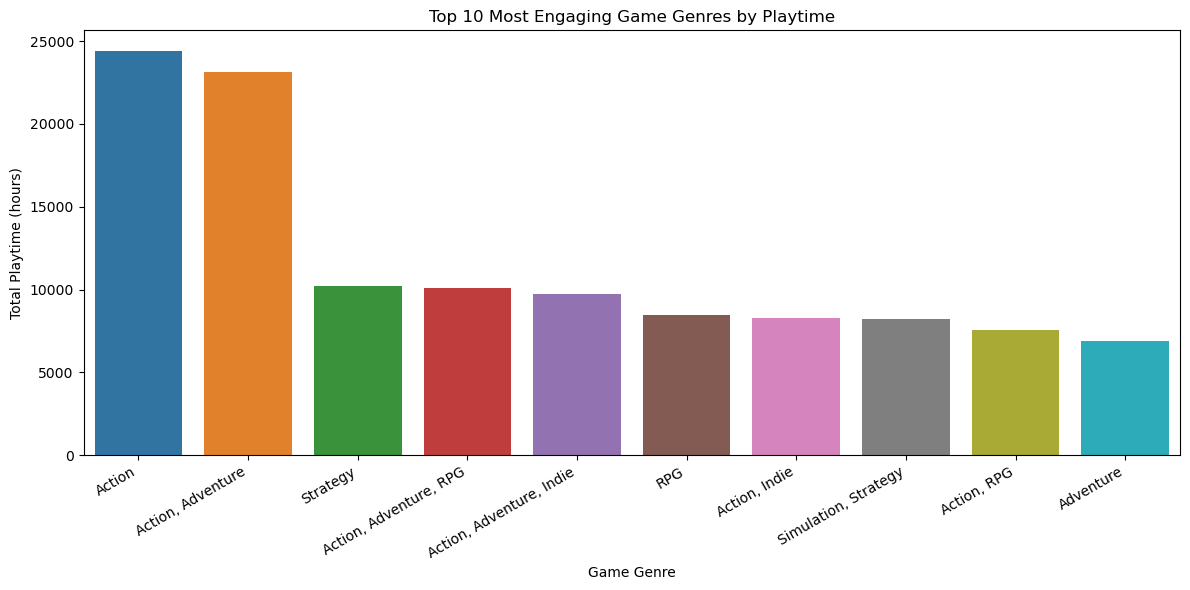

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]
merged_data = merged_data[merged_data['playtime_2weeks'] < 40]

genre_playtime = merged_data.groupby("genre")["playtime_2weeks"].sum().sort_values(ascending=False)

# Plot genre vs. total playtime
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_playtime.index[:10], y=genre_playtime.values[:10])
plt.xticks(rotation=30, ha="right")  # Rotating labels for better readability
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

addiction_correlation, _ = pearsonr(merged_data["playtime_forever"], merged_data["average_review_score"])


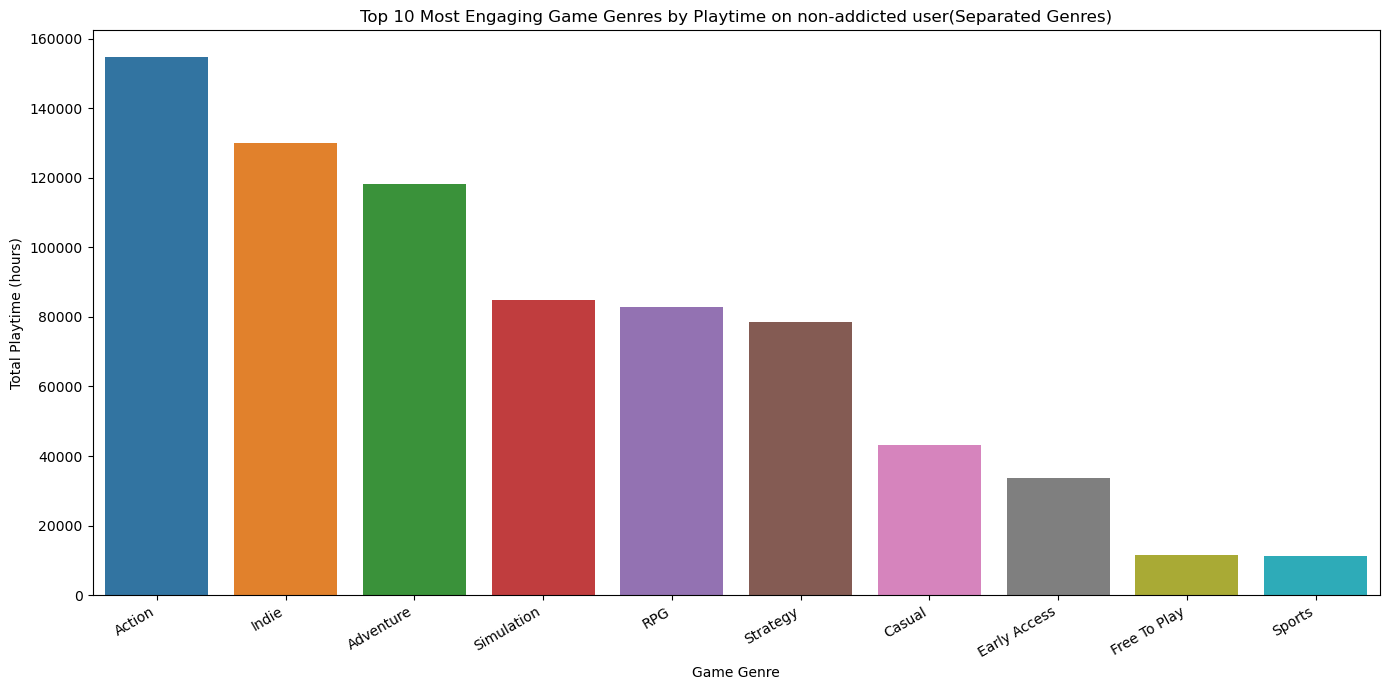

In [52]:
from collections import defaultdict

# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]
merged_data = merged_data[merged_data['playtime_2weeks'] < 40]

genre_playtime = merged_data.groupby("genre")["playtime_2weeks"].sum().sort_values(ascending=False)

# Spliting genres and sum playtime for each individual genre
genre_playtime_dict = defaultdict(int)

for _, row in merged_data.iterrows():
    genres = row["genre"].split(", ")  # Split multiple genres
    for genre in genres:
        genre_playtime_dict[genre] += row["playtime_2weeks"]

genre_playtime_df = pd.DataFrame(list(genre_playtime_dict.items()), columns=["Genre", "Total Playtime"])
genre_playtime_df = genre_playtime_df.sort_values(by="Total Playtime", ascending=False)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_playtime_df["Genre"][:10], y=genre_playtime_df["Total Playtime"][:10])
plt.xticks(rotation=30, ha="right")  # Rotate labels for clarity
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime on non-addicted user(Separated Genres)")
plt.tight_layout()
plt.show()


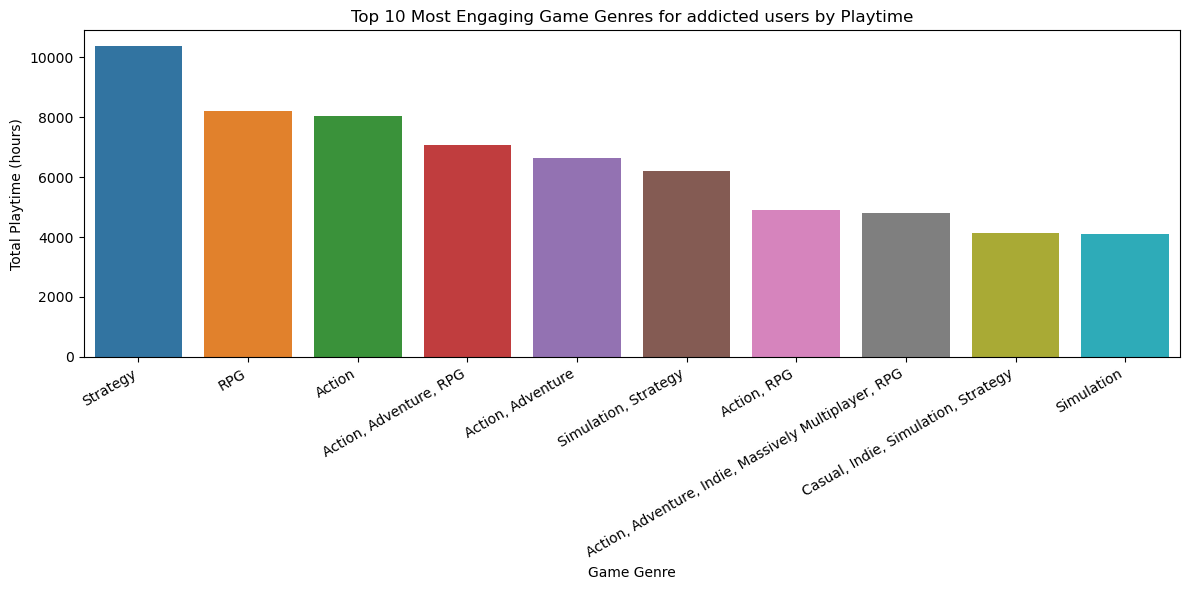

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

merged_data = merged_data[merged_data['playtime_2weeks'] > 40]

genre_playtime = merged_data.groupby("genre")["playtime_2weeks"].sum().sort_values(ascending=False)

# Plot genre vs. total playtime
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_playtime.index[:10], y=genre_playtime.values[:10])
plt.xticks(rotation=30, ha="right")  # Rotating labels for better readability
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres for addicted users by Playtime")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

addiction_correlation, _ = pearsonr(merged_data["playtime_forever"], merged_data["average_review_score"])


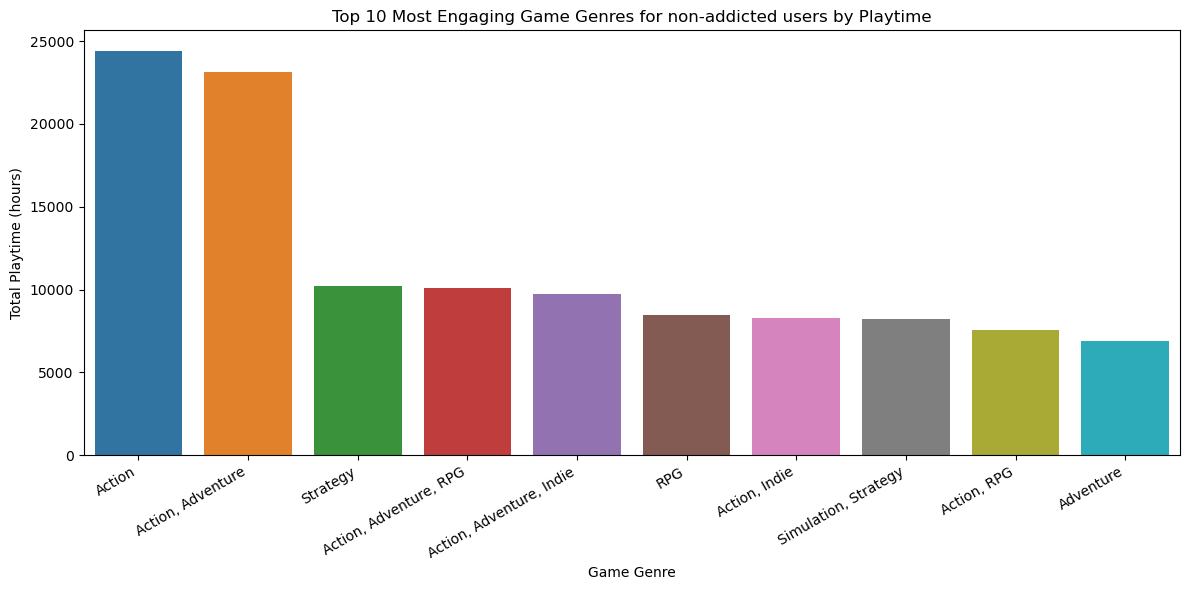

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

merged_data = merged_data[merged_data['playtime_2weeks'] > 0]

merged_data = merged_data[merged_data['playtime_2weeks'] < 40]

genre_playtime = merged_data.groupby("genre")["playtime_2weeks"].sum().sort_values(ascending=False)

# Plot genre vs. total playtime
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_playtime.index[:10], y=genre_playtime.values[:10])
plt.xticks(rotation=30, ha="right")  # Rotating labels for better readability
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres for non-addicted users by Playtime")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

addiction_correlation, _ = pearsonr(merged_data["playtime_forever"], merged_data["average_review_score"])


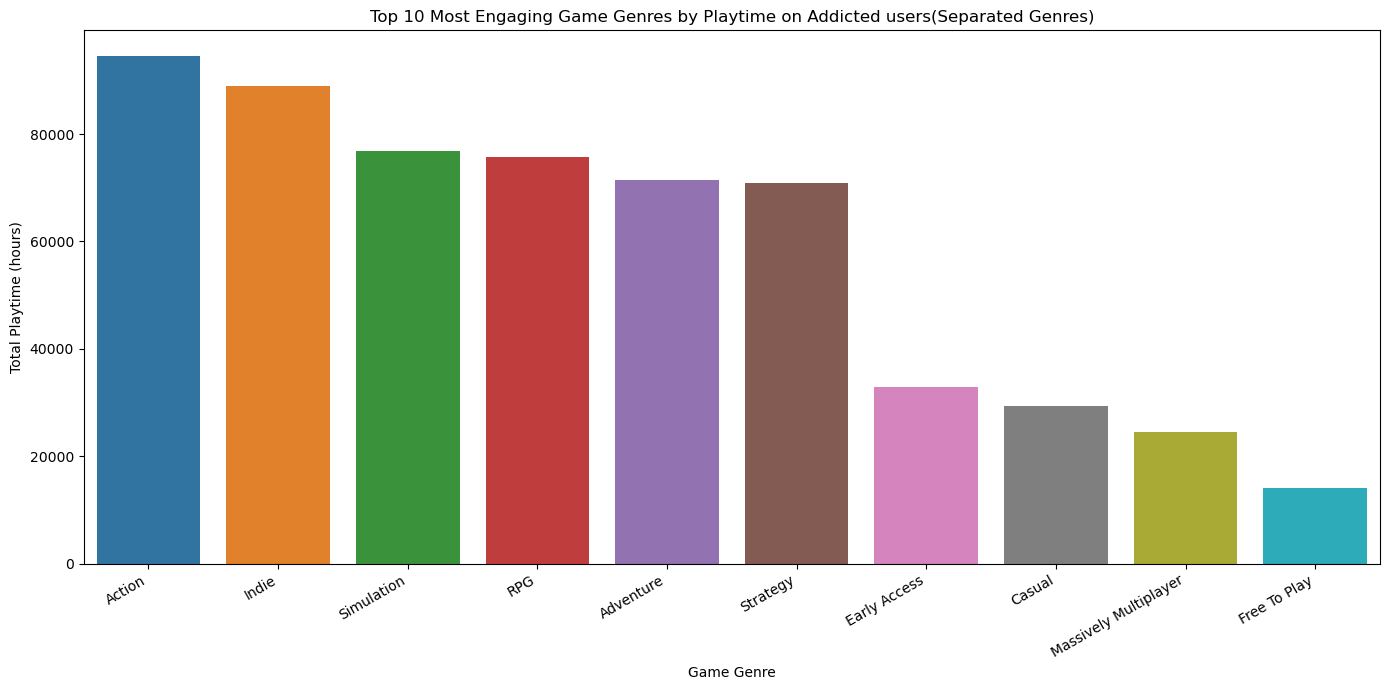

In [55]:
from collections import defaultdict

# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

merged_data = merged_data[merged_data['playtime_2weeks'] > 40]
merged_data['multiplayer_support'] = merged_data['multiplayer_support'].astype(int)


genre_playtime = merged_data.groupby("genre")["playtime_2weeks"].sum().sort_values(ascending=False)


# Spliting genres and sum playtime for each individual genre
genre_playtime_dict = defaultdict(int)

for _, row in merged_data.iterrows():
    genres = row["genre"].split(", ")  # Split multiple genres
    for genre in genres:
        genre_playtime_dict[genre] += row["playtime_2weeks"]

genre_playtime_df = pd.DataFrame(list(genre_playtime_dict.items()), columns=["Genre", "Total Playtime"])
genre_playtime_df = genre_playtime_df.sort_values(by="Total Playtime", ascending=False)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_playtime_df["Genre"][:10], y=genre_playtime_df["Total Playtime"][:10])
plt.xticks(rotation=30, ha="right")  # Rotate labels for clarity
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime on Addicted users(Separated Genres)")
plt.tight_layout()
plt.show()


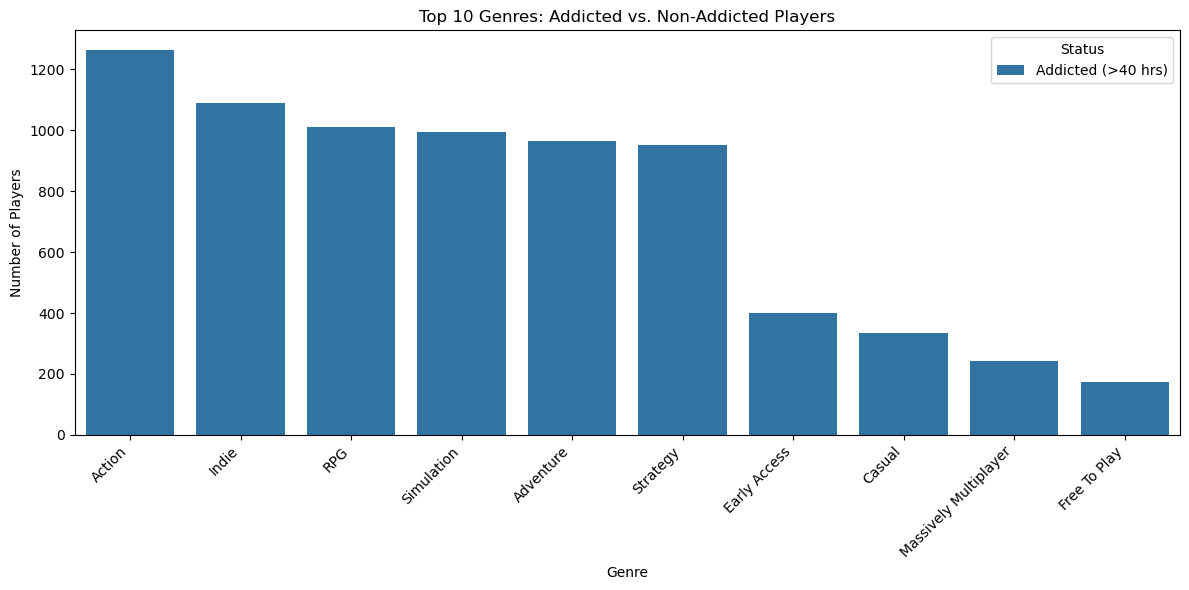

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and create addicted column
df_filtered = merged_data[merged_data['playtime_2weeks'] > 0].copy()
df_filtered['addicted'] = (df_filtered['playtime_2weeks'] > 40).astype(int)

# Split the 'genre' column into individual genre tags (if comma-separated)
df_filtered['genre_list'] = df_filtered['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# Explode the list so each genre appears in its own row
df_exploded = df_filtered.explode('genre_list').rename(columns={'genre_list': 'genre_tag'})

# Count the number of players for each genre and addiction status
counts = df_exploded.groupby(['genre_tag', 'addicted']).size().reset_index(name='count')

# Compute total count per genre
total_counts = counts.groupby('genre_tag')['count'].sum().reset_index(name='Total_Count')

# Select top 10 genres by total count
top_genres = total_counts.sort_values('Total_Count', ascending=False).head(10)['genre_tag']
counts_top = counts[counts['genre_tag'].isin(top_genres)].copy()

# Map addicted values to labels for clarity
counts_top['Status'] = counts_top['addicted'].map({0: 'Non-Addicted (0-40 hrs)', 
                                                    1: 'Addicted (>40 hrs)'})

# Order genre_tag based on total count descending
order = total_counts[total_counts['genre_tag'].isin(top_genres)].sort_values('Total_Count', ascending=False)['genre_tag']
counts_top['genre_tag'] = pd.Categorical(counts_top['genre_tag'], categories=order, ordered=True)

# Plotting the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='genre_tag', y='count', hue='Status', data=counts_top)
plt.xlabel('Genre')
plt.ylabel('Number of Players')
plt.title('Top 10 Genres: Addicted vs. Non-Addicted Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Q4. Do highly addictive games tend to have higher or lower ratings, and what are the most common sentiments expressed in player reviews? 

In [57]:
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

# get the title from the games_data
df_reviews = merged_data.merge(reviews_data, on='game_id', how='inner')


# get the title from the games_data
#df_reviews = reviews_data.merge(games_data[['game_id', 'title']], on='game_id', how='left')


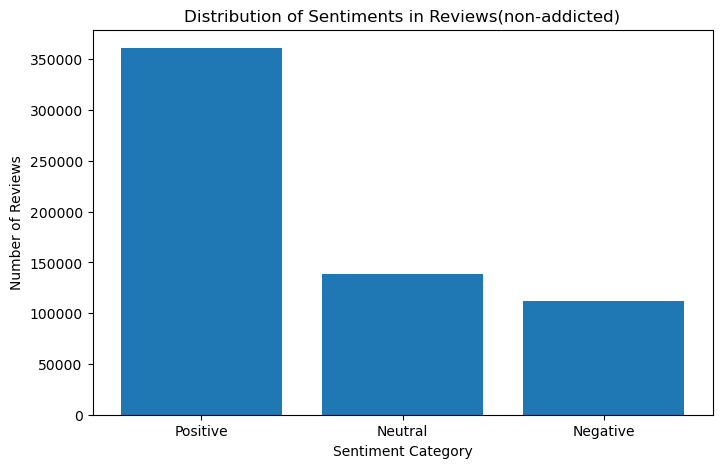

In [58]:
import re
import matplotlib.pyplot as plt
from textblob import TextBlob


df_reviews = df_reviews[df_reviews['playtime_2weeks'] > 0]

df_reviews = df_reviews[df_reviews['playtime_2weeks'] < 40]


#df_reviews= reviews_data

# Function to clean review text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\[.*?\]", "", text)  # Removing tags like [h1], [b], etc.
    text = re.sub(r"http\S+|www\S+", "", text)  # Removng URLs
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

# Apply text cleaning
df_reviews["cleaned_review"] = df_reviews["review"].apply(clean_text)

# Function to get sentiment polarity
def get_sentiment(text):
    if not text:  # If empty text, return neutral
        return 0  
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the cleaned reviews
df_reviews["sentiment_score"] = df_reviews["cleaned_review"].apply(get_sentiment)

# Classify reviews based on sentiment score
df_reviews["sentiment"] = df_reviews["sentiment_score"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

# Count of each sentiment category
sentiment_counts = df_reviews["sentiment"].value_counts()

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments in Reviews(non-addicted)")
plt.show()

# sentiment by game
game_sentiment = df_reviews.groupby("title")["sentiment_score"].mean().reset_index()

# Top 10 most positively reviewed games
top_positive_games = game_sentiment.sort_values(by="sentiment_score", ascending=False).head(10)

# Top 10 most negatively reviewed games
top_negative_games = game_sentiment.sort_values(by="sentiment_score", ascending=True).head(10)

# Display results

#print("Sentiment Analysis Results", df_reviews)
#print("Top Positive Games", top_positive_games)
#print("Top Negative Games", top_negative_games)


In [59]:
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

# get the title from the games_data
df_reviews = merged_data.merge(reviews_data, on='game_id', how='inner')


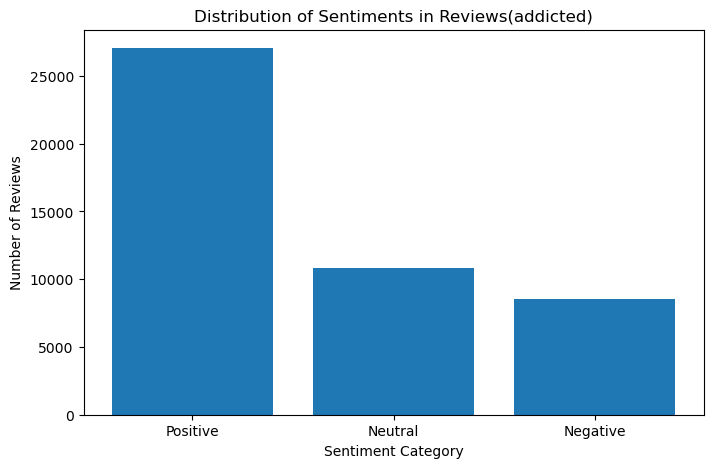

In [60]:


df_reviews = df_reviews[df_reviews['playtime_2weeks'] > 40]

#df_reviews= reviews_data

# Function to clean review text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\[.*?\]", "", text)  # Removing tags like [h1], [b], etc.
    text = re.sub(r"http\S+|www\S+", "", text)  # Removng URLs
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

# Apply text cleaning
df_reviews["cleaned_review"] = df_reviews["review"].apply(clean_text)

# Function to get sentiment polarity
def get_sentiment(text):
    if not text:  # If empty text, return neutral
        return 0  
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the cleaned reviews
df_reviews["sentiment_score"] = df_reviews["cleaned_review"].apply(get_sentiment)

# Classify reviews based on sentiment score
df_reviews["sentiment"] = df_reviews["sentiment_score"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

# Count of each sentiment category
sentiment_counts = df_reviews["sentiment"].value_counts()

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments in Reviews(addicted)")
plt.show()

# sentiment by game
game_sentiment = df_reviews.groupby("title")["sentiment_score"].mean().reset_index()

# Top 10 most positively reviewed games
top_positive_games = game_sentiment.sort_values(by="sentiment_score", ascending=False).head(10)

# Top 10 most negatively reviewed games
top_negative_games = game_sentiment.sort_values(by="sentiment_score", ascending=True).head(10)

# Display results

#print("Sentiment Analysis Results", df_reviews)
#print("Top Positive Games", top_positive_games)
#print("Top Negative Games", top_negative_games)




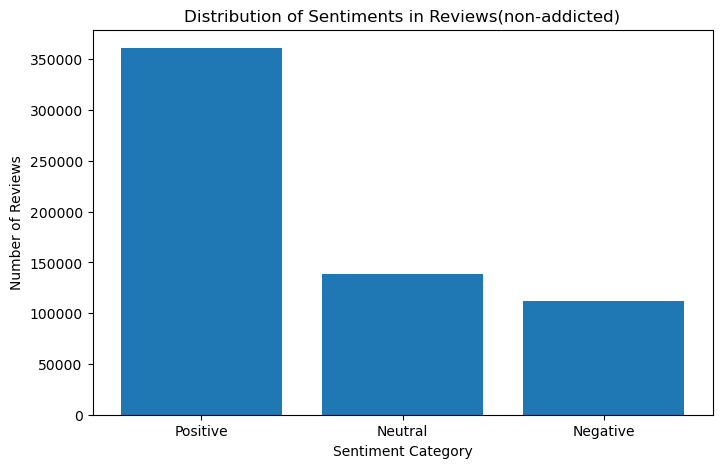

In [61]:

merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

# get the title from the games_data
df_reviews = merged_data.merge(reviews_data, on='game_id', how='inner')


df_reviews = df_reviews[df_reviews['playtime_2weeks'] < 40]
df_reviews = df_reviews[df_reviews['playtime_2weeks'] > 0]

#df_reviews= reviews_data

# Function to clean review text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\[.*?\]", "", text)  # Removing tags like [h1], [b], etc.
    text = re.sub(r"http\S+|www\S+", "", text)  # Removng URLs
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

# Apply text cleaning
df_reviews["cleaned_review"] = df_reviews["review"].apply(clean_text)

# Function to get sentiment polarity
def get_sentiment(text):
    if not text:  # If empty text, return neutral
        return 0  
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the cleaned reviews
df_reviews["sentiment_score"] = df_reviews["cleaned_review"].apply(get_sentiment)

# Classify reviews based on sentiment score
df_reviews["sentiment"] = df_reviews["sentiment_score"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

# Count of each sentiment category
sentiment_counts = df_reviews["sentiment"].value_counts()

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments in Reviews(non-addicted)")
plt.show()

# sentiment by game
game_sentiment = df_reviews.groupby("title")["sentiment_score"].mean().reset_index()

# Top 10 most positively reviewed games
top_positive_games = game_sentiment.sort_values(by="sentiment_score", ascending=False).head(10)

# Top 10 most negatively reviewed games
top_negative_games = game_sentiment.sort_values(by="sentiment_score", ascending=True).head(10)

# Display results

#print("Sentiment Analysis Results", df_reviews)
#print("Top Positive Games", top_positive_games)
#print("Top Negative Games", top_negative_games)


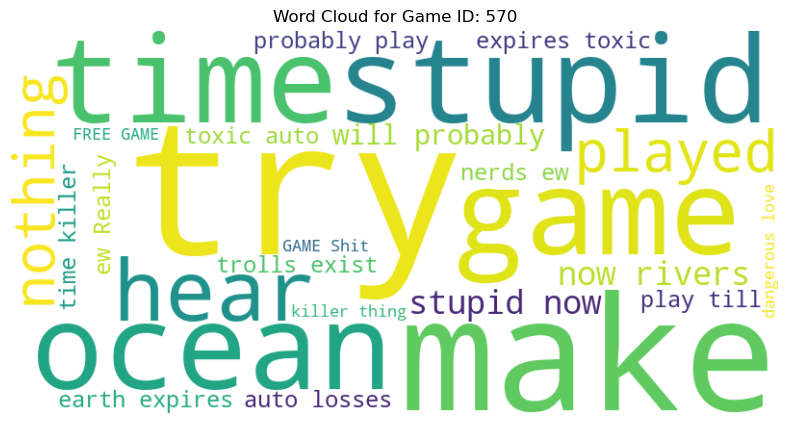

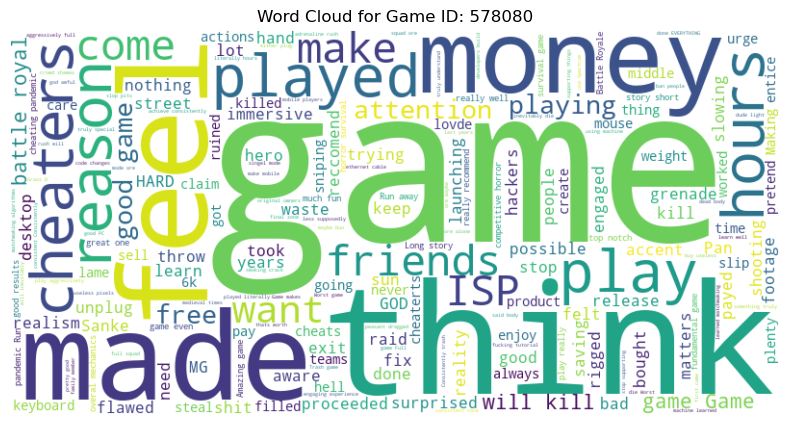

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# List of top 10 game IDs for analysis
top_game_ids = list(most_popular_games['game_id'])[1:3]


# Filter reviews for these games
df_top_games_reviews = df_reviews[df_reviews["game_id"].isin(top_game_ids)]


# Generate and display word clouds for each game
for game_id in top_game_ids:
    game_reviews = df_top_games_reviews[df_top_games_reviews["game_id"] == game_id]["review"].dropna()
    text = " ".join(game_reviews)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Game ID: {game_id}")
    plt.show()


# Predictive Modeling

In [63]:
users_data["playtime_2weeks"] = pd.to_numeric(users_data["playtime_2weeks"], errors="coerce").fillna(0)
users_data["playtime_per_week"] = users_data["playtime_2weeks"] / 2
threshold_hours = 20  
users_data["addicted"] = (users_data["playtime_per_week"] > threshold_hours).astype(int)  # Binary target variable

In [64]:
merged_data = users_data.merge(games_data, on="game_id", how="inner")
# Counting the number of people who are addicted (1) and not addicted (0)
addiction_counts = merged_data['addicted'].value_counts()

# Displaying the counts
addiction_counts

# Drop unwanted columns
merged_data = merged_data.drop(columns=['name'])

# Convert 'release_date' to numeric year
merged_data['release_year'] = pd.to_datetime(merged_data['release_date'], errors='coerce').dt.year

# Drop the original 'release_date' column
merged_data = merged_data.drop(columns=['release_date'])


In [65]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Assuming merged_data is your DataFrame
X = merged_data.drop(columns=['addicted'])  # Features
y = merged_data['addicted']  # Target

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # 1:1 balance
X_resampled, y_resampled = rus.fit_resample(X, y)

balanced_data = pd.concat([X_resampled, y_resampled], axis=1)
print(balanced_data['addicted'].value_counts())  # Should show ~197 of each class


addicted
0    2682
1    2682
Name: count, dtype: int64


In [66]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315842 entries, 0 to 315841
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 315842 non-null  int64  
 1   game_count              315842 non-null  int64  
 2   game_id                 315842 non-null  int64  
 3   playtime_forever        315842 non-null  float64
 4   playtime_2weeks         315842 non-null  float64
 5   avg_playtime            315842 non-null  float64
 6   playtime_per_week       315842 non-null  float64
 7   addicted                315842 non-null  int64  
 8   title                   315842 non-null  object 
 9   developer               315842 non-null  object 
 10  publisher               315842 non-null  object 
 11  genre                   315842 non-null  object 
 12  platforms               315842 non-null  object 
 13  multiplayer_support     315842 non-null  bool   
 14  graphics_quality    

In [67]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5364 entries, 0 to 5363
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 5364 non-null   int64  
 1   game_count              5364 non-null   int64  
 2   game_id                 5364 non-null   int64  
 3   playtime_forever        5364 non-null   float64
 4   playtime_2weeks         5364 non-null   float64
 5   avg_playtime            5364 non-null   float64
 6   playtime_per_week       5364 non-null   float64
 7   title                   5364 non-null   object 
 8   developer               5364 non-null   object 
 9   publisher               5364 non-null   object 
 10  genre                   5364 non-null   object 
 11  platforms               5364 non-null   object 
 12  multiplayer_support     5364 non-null   bool   
 13  graphics_quality        5364 non-null   object 
 14  story_depth             5364 non-null   

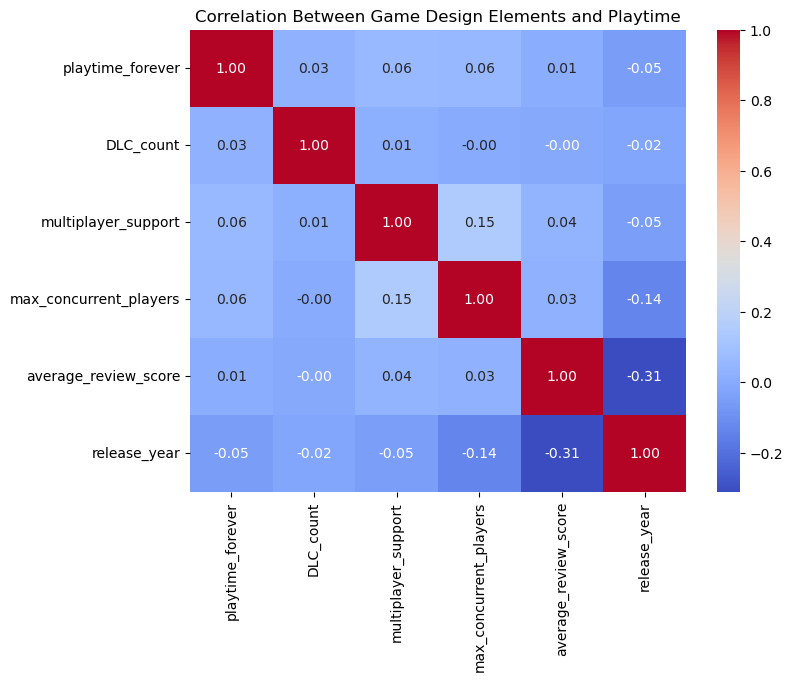

In [68]:
# since we have balanced data, let's check if any change in correlation
# game design elements for analysis 
design_elements = ["DLC_count", "multiplayer_support", "max_concurrent_players", 
                    "average_review_score", "release_year"]

# correlation of game design elements with playtime_forever
correlation_results = balanced_data[["playtime_forever"] + design_elements].corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Game Design Elements and Playtime")
plt.show()


Accuracy: 0.7856

Classification Report:
              precision    recall  f1-score
Not Addicted   0.810101  0.746741  0.777132
Addicted       0.764706  0.824627  0.793537


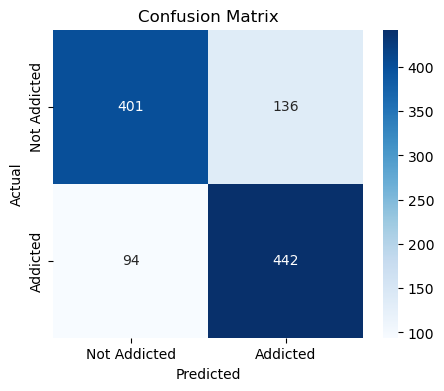


Top Feature Importance:
game_count: 3.6727
genre_Adventure, Indie: 1.5562
genre_Strategy: 1.4932
developer_Eridanus Industries: 1.4380
genre_Adventure, Indie, RPG, Strategy: 1.4006
genre_Casual, Indie: 1.3735
genre_RPG: 1.3643
genre_Indie: 1.2848
developer_BioWare: 1.2798
genre_Action, Adventure, Massively Multiplayer, RPG, Simulation, Strategy: 1.2561
publisher_Starbreeze Publishing AB: 1.2321
genre_Indie, RPG, Simulation, Strategy, Early Access: 1.2115
publisher_Techland: 1.2043
genre_Action, Adventure, Casual, Indie, Simulation: 1.1705
genre_Action, Adventure, Indie: 1.1527
developer_Piranha Bytes: 1.1486
genre_Massively Multiplayer, RPG: 1.1354
developer_Thekla, Inc.: 1.1331
publisher_Thekla, Inc.: 1.1331
developer_Sparkypants: 1.1290


In [69]:

# define feature columns
numerical_features = ['game_count', 'DLC_count', 'max_concurrent_players', 'release_year',
                     'average_review_score','number_of_reviews']

categorical_features = ['developer', 'publisher', 'genre', 'platforms', 
                        'multiplayer_support', 'graphics_quality' , 'story_depth']

# selecting all features except for removed ones
X = balanced_data[numerical_features + categorical_features]
y = balanced_data['addicted']

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline => Logistic Regression Model 
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=500))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_pred = log_reg_pipeline.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_logisitc = pd.DataFrame(filtered_report).T
print(filtered_report_logisitc)

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Addicted', 'Addicted'], yticklabels=['Not Addicted', 'Addicted'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get Feature Importance
feature_names = (numerical_features + 
                 list(log_reg_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))
feature_importance = np.abs(log_reg_pipeline.named_steps['classifier'].coef_).flatten()

sorted_indices = np.argsort(feature_importance)[::-1]

print("\nTop Feature Importance:")
for idx in sorted_indices[:20]:  # Display top 20 most important features
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")


Accuracy: 0.8034

Classification Report:
              precision    recall  f1-score
Not Addicted   0.814672  0.785847  0.800000
Addicted       0.792793  0.820896  0.806599


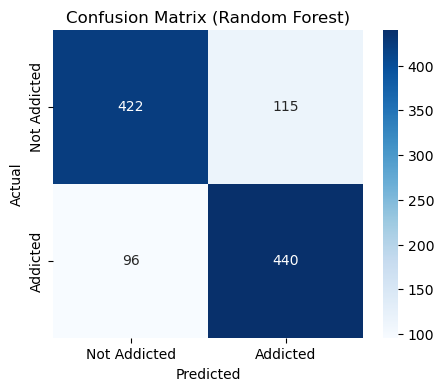


Top Feature Importance:
game_count: 0.2605
max_concurrent_players: 0.0761
number_of_reviews: 0.0686
release_year: 0.0549
DLC_count: 0.0265
average_review_score: 0.0189
genre_Action: 0.0074
genre_Action, Adventure, Indie: 0.0060
multiplayer_support_False: 0.0047
platforms_windows: 0.0045
multiplayer_support_True: 0.0043
genre_Strategy: 0.0039
genre_RPG: 0.0038
platforms_windows, mac, linux: 0.0035
genre_Adventure, Indie: 0.0033
story_depth_Deep: 0.0032
genre_Simulation, Strategy: 0.0031
story_depth_Light: 0.0030
genre_Action, Adventure: 0.0029
genre_Action, Adventure, RPG: 0.0029


In [70]:
# define numerical and categorical features
numerical_features = ['game_count', 'DLC_count', 'max_concurrent_players',
                      'average_review_score', 'number_of_reviews', 'release_year']

categorical_features = ['developer', 'publisher', 'genre', 'platforms', 
                        'multiplayer_support', 'graphics_quality', 'story_depth']

# dataset
X = balanced_data[numerical_features + categorical_features]
y = balanced_data['addicted']

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Random Forest Model
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train the model
random_forest_pipeline.fit(X_train, y_train)

# Predictions
y_pred = random_forest_pipeline.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")

# generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_randomforest = pd.DataFrame(filtered_report).T
print(filtered_report_randomforest)

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Addicted', 'Addicted'], yticklabels=['Not Addicted', 'Addicted'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

# Feature Importance Analysis
feature_names = (numerical_features + 
                 list(random_forest_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))

feature_importance = random_forest_pipeline.named_steps['classifier'].feature_importances_

# Sort and display top features
sorted_indices = np.argsort(feature_importance)[::-1]

print("\nTop Feature Importance:")
for idx in sorted_indices[:20]:  # Display top 20 most important features
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")


XGBoost Accuracy: 0.8192

XGBoost Classification Report:
              precision    recall  f1-score
Not Addicted   0.861053  0.761639  0.808300
Addicted       0.785953  0.876866  0.828924


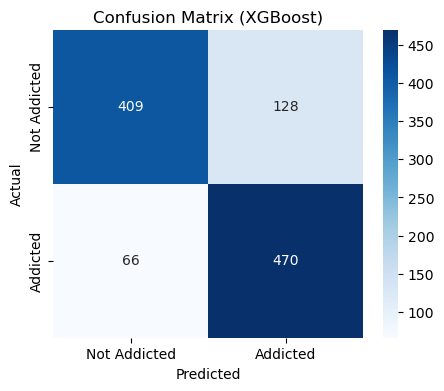


Top Feature Importance (XGBoost):
game_count: 0.0285
developer_Aurora Studio: 0.0220
number_of_reviews: 0.0219
genre_Casual: 0.0195
genre_Action: 0.0193
genre_Action, Adventure, Indie: 0.0180
publisher_Slitherine Ltd.: 0.0166
max_concurrent_players: 0.0147
publisher_Valve: 0.0144
publisher_Team17: 0.0140
genre_Adventure: 0.0134
publisher_Digital Extremes: 0.0134
genre_Action, Strategy, Free To Play: 0.0131
genre_Action, Free To Play, Massively Multiplayer: 0.0130
developer_Grinding Gear Games: 0.0127
release_year: 0.0126
genre_RPG: 0.0120
publisher_Electronic Arts: 0.0119
genre_Action, Casual, Indie: 0.0114
genre_Strategy: 0.0110


In [71]:
# Import necessary libraries
from xgboost import XGBClassifier


# Define XGBoost model pipeline
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                                 subsample=0.8, colsample_bytree=0.8, random_state=42, 
                                 scale_pos_weight=1.0))  # Handles class imbalance
])

# Train the XGBoost model
xgboost_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgboost_pipeline.predict(X_test)

# Evaluation Metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Display results
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}\n")
print("XGBoost Classification Report:")
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_xgb, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# Convert to DataFrame for clean display
filtered_report_xgboost = pd.DataFrame(filtered_report).T

# Display the modified classification report
print(filtered_report_xgboost)

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Addicted', 'Addicted'], yticklabels=['Not Addicted', 'Addicted'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Feature Importance Analysis
feature_names_xgb = (numerical_features + 
                 list(xgboost_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))

feature_importance_xgb = xgboost_pipeline.named_steps['classifier'].feature_importances_

# Sort and display top features
sorted_indices_xgb = np.argsort(feature_importance_xgb)[::-1]

print("\nTop Feature Importance (XGBoost):")
for idx in sorted_indices_xgb[:20]:  # Display top 20 most important features
    print(f"{feature_names_xgb[idx]}: {feature_importance_xgb[idx]:.4f}")


KNN Accuracy: 0.7222739981360671
              precision    recall  f1-score
Not Addicted   0.755889  0.657356  0.703187
Addicted       0.696370  0.787313  0.739054


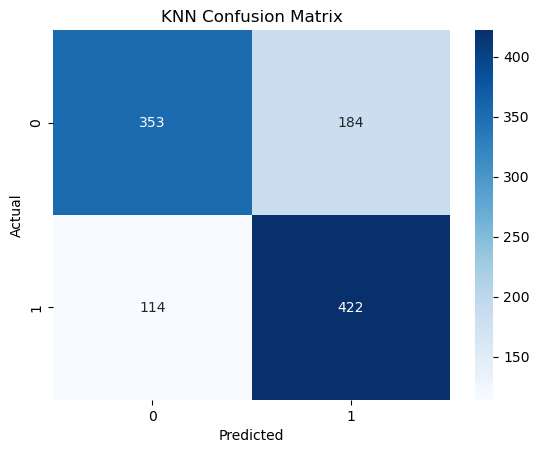

In [72]:
from sklearn.neighbors import KNeighborsClassifier

# Define KNN model pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Train KNN model
knn_pipeline.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluation
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_knn, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_knn = pd.DataFrame(filtered_report).T

# Display the modified classification report
print(filtered_report_knn)
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap="Blues", fmt="d")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SGD Classification Report:

   precision    recall  f1-score
0   0.882353  0.586592  0.704698
1   0.689944  0.921642  0.789137
SGD Accuracy: 0.7539608574091333


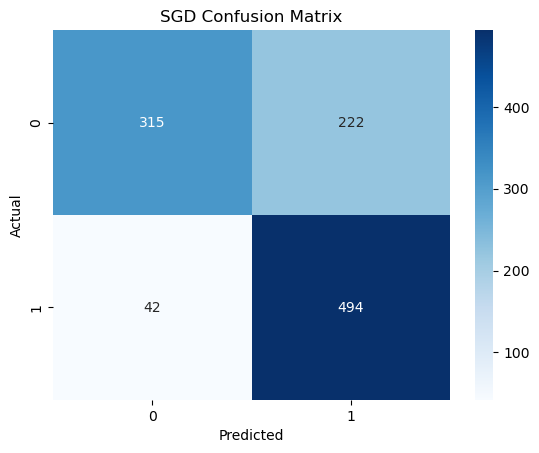

In [73]:
from sklearn.linear_model import SGDClassifier

# Define SGD model pipeline
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss="log_loss", max_iter=1000, random_state=42))
])

# Train SGD model
sgd_pipeline.fit(X_train, y_train)

# Predictions
y_pred_sgd = sgd_pipeline.predict(X_test)

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_sgd, output_dict=True)

# Extract only precision, recall, and f1-score for class 0 and class 1
filtered_report = {label: {metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']} 
                   for label in ['0', '1']}

filtered_report_sgd = pd.DataFrame(filtered_report).T
print("SGD Classification Report:\n")
print(filtered_report_sgd)
# Evaluation
print("SGD Accuracy:", accuracy_score(y_test, y_pred_sgd))
sns.heatmap(confusion_matrix(y_test, y_pred_sgd), annot=True, cmap="Blues", fmt="d")
plt.title("SGD Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




Bagging Accuracy: 0.8005591798695247
              precision    recall  f1-score
Not Addicted   0.823647  0.765363  0.793436
Addicted       0.780488  0.835821  0.807207


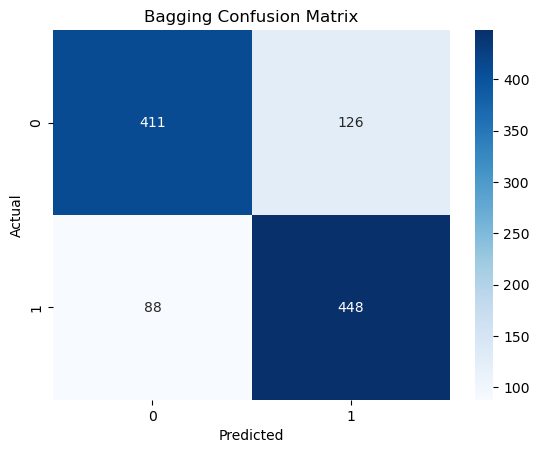

In [74]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define Bagging model pipeline
bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), 
                                     n_estimators=100, random_state=42))
])

# Train Bagging model
bagging_pipeline.fit(X_train, y_train)

# Predictions
y_pred_bagging = bagging_pipeline.predict(X_test)

# Evaluation
print("Bagging Accuracy:", accuracy_score(y_test, y_pred_bagging))
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_bagging, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_bagging = pd.DataFrame(filtered_report).T

# Display the modified classification report
print(filtered_report_bagging)
sns.heatmap(confusion_matrix(y_test, y_pred_bagging), annot=True, cmap="Blues", fmt="d")
plt.title("Bagging Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




Decision Tree Accuracy: 0.7977632805219013
Decision Tree Classification Report:

              precision    recall  f1-score
Not Addicted    0.87037  0.700186  0.776058
Addicted        0.74883  0.895522  0.815633


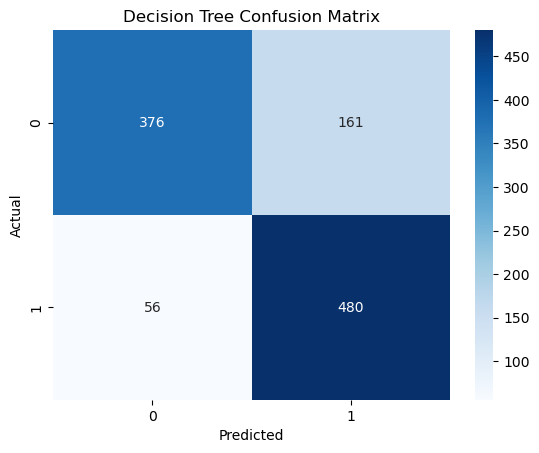

In [75]:
from sklearn.tree import DecisionTreeClassifier

# Define Decision Tree model pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=42))
])

# Train Decision Tree model
dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluation
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n")
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_dt, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_decisiontree = pd.DataFrame(filtered_report).T
print(filtered_report_decisiontree)
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Linear SVM Accuracy: 0.7781919850885368
              precision    recall  f1-score
Not Addicted   0.809524  0.728119  0.766667
Addicted       0.752542  0.828358  0.788632


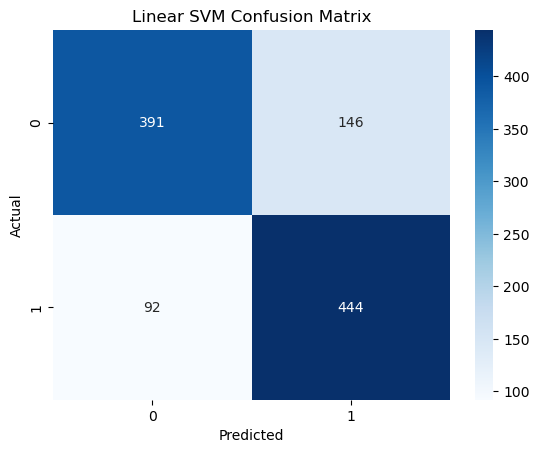

In [76]:
from sklearn.svm import SVC

# Define Linear SVM model pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1.0, random_state=42))
])

# Train SVM model
svm_pipeline.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluation
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_svm, output_dict=True)

# Extract only precision, recall, and f1-score, renaming "0" → "Not Addicted" and "1" → "Addicted"
filtered_report = {
    "Not Addicted" if label == "0" else "Addicted": {
        metric: report[label][metric] for metric in ['precision', 'recall', 'f1-score']
    }
    for label in ["0", "1"]  # Only include class-specific metrics
}

# converting to df
filtered_report_svm = pd.DataFrame(filtered_report).T

# Display the modified classification report
print(filtered_report_svm)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt="d")
plt.title("Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


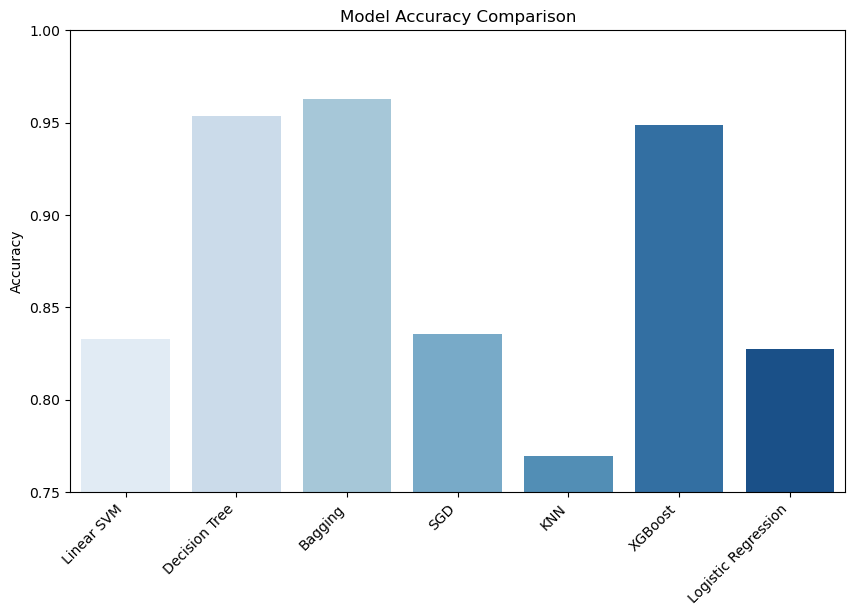

In [77]:

models = ["Linear SVM", "Decision Tree", "Bagging", "SGD", "KNN", "XGBoost", "Logistic Regression"]
accuracies = [0.8331, 0.9534, 0.9630, 0.8354, 0.7698, 0.9487, 0.8276]

# bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette="Blues")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.ylim(0.75, 1.0)  # Keep y-axis within accuracy range for better visibility
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


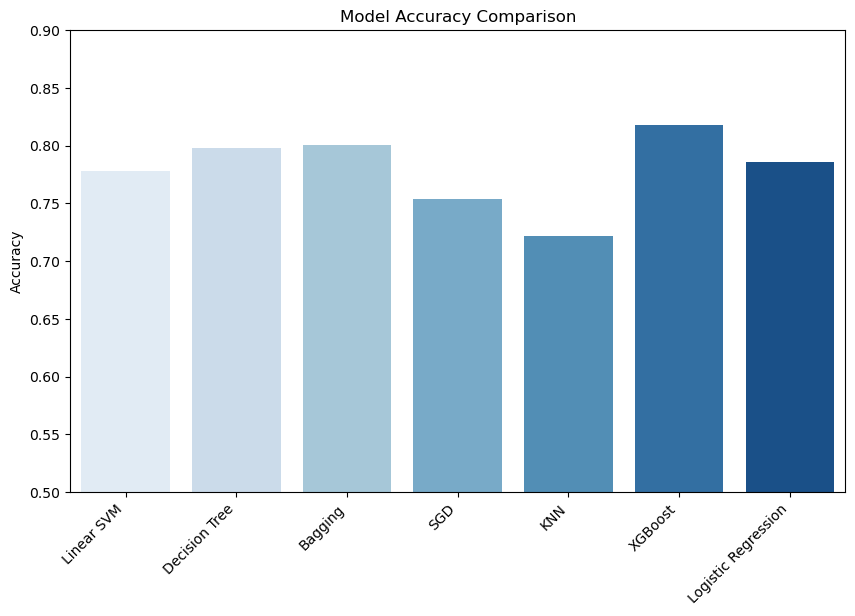

In [78]:

models = ["Linear SVM", "Decision Tree", "Bagging", "SGD", "KNN", "XGBoost", "Logistic Regression"]
accuracies = [0.778, 0.7977, 0.8005, 0.7539, 0.7220, 0.8182, 0.7856]

# bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette="Blues")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.ylim(0.5, 0.9)  # Keep y-axis within accuracy range for better visibility
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [81]:
precision_scores

[0.8101010101010101,
 0.8610526315789474,
 0.7558886509635975,
 0.8236472945891784,
 0.8703703703703703,
 0.8095238095238095]

In [82]:
recall_scores

[0.7467411545623837,
 0.7616387337057728,
 0.6573556797020484,
 0.7653631284916201,
 0.7001862197392924,
 0.7281191806331471]

In [83]:
f1_scores

[0.7771317829457365,
 0.808300395256917,
 0.703187250996016,
 0.7934362934362935,
 0.7760577915376677,
 0.7666666666666667]

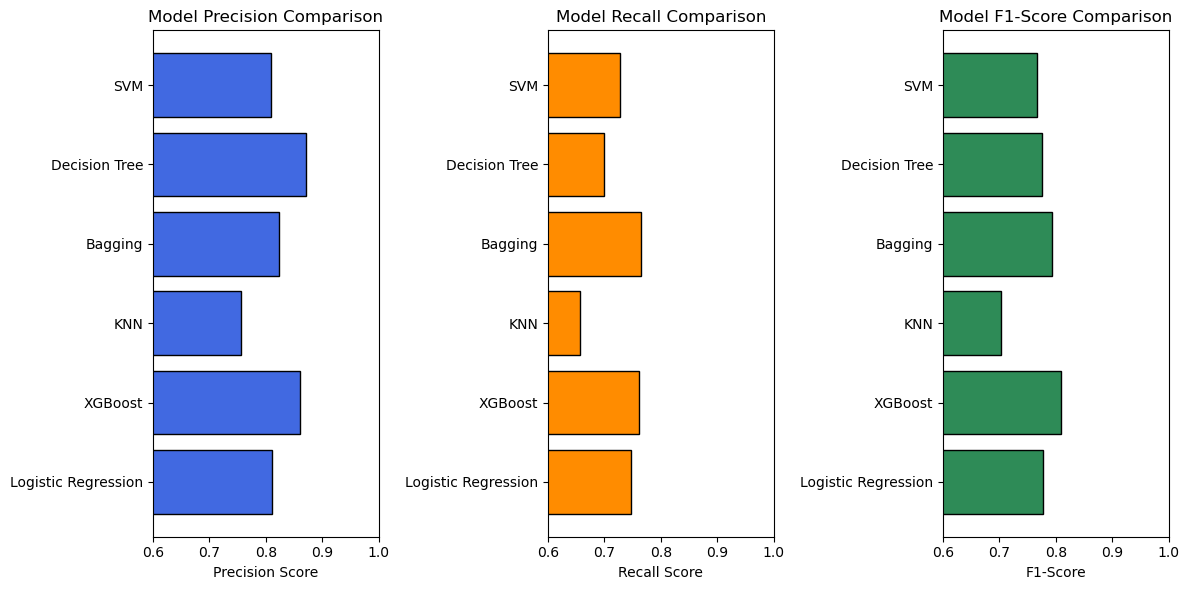

In [79]:
# Sample structure assuming the reports are available
# Recreate the filtered reports using placeholder values (replace with actual DataFrames)

# Define model names
model_names = ["Logistic Regression", "XGBoost", "KNN", "Bagging", "Decision Tree", "SVM"]

# Extract precision, recall, and F1-score from the filtered reports for the "Not Addicted" class
precision_scores = [
    filtered_report_logisitc.loc["Not Addicted", "precision"],
    filtered_report_xgboost.loc["Not Addicted", "precision"],
    filtered_report_knn.loc["Not Addicted", "precision"],
    #filtered_report_sgd.loc["Not Addicted", "precision"],
    filtered_report_bagging.loc["Not Addicted", "precision"],
    filtered_report_decisiontree.loc["Not Addicted", "precision"],
    filtered_report_svm.loc["Not Addicted", "precision"]
]

recall_scores = [
    filtered_report_logisitc.loc["Not Addicted", "recall"],
    filtered_report_xgboost.loc["Not Addicted", "recall"],
    filtered_report_knn.loc["Not Addicted", "recall"],
    #filtered_report_sgd.loc["Not Addicted", "recall"],
    filtered_report_bagging.loc["Not Addicted", "recall"],
    filtered_report_decisiontree.loc["Not Addicted", "recall"],
    filtered_report_svm.loc["Not Addicted", "recall"]
]

f1_scores = [
    filtered_report_logisitc.loc["Not Addicted", "f1-score"],
    filtered_report_xgboost.loc["Not Addicted", "f1-score"],
    filtered_report_knn.loc["Not Addicted", "f1-score"],
    #filtered_report_sgd.loc["Not Addicted", "f1-score"],
    filtered_report_bagging.loc["Not Addicted", "f1-score"],
    filtered_report_decisiontree.loc["Not Addicted", "f1-score"],
    filtered_report_svm.loc["Not Addicted", "f1-score"]
]

# Create a DataFrame for visualization
df_comparison = pd.DataFrame({
    "Model": model_names,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1-Score": f1_scores
})

# Plot comparison of Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))

# Precision plot
plt.subplot(1, 3, 1)
plt.barh(df_comparison["Model"], df_comparison["Precision"], color='royalblue', edgecolor='black')
plt.xlabel("Precision Score")
plt.title("Model Precision Comparison")
plt.xlim(0.6, 1.0)

# Recall plot
plt.subplot(1, 3, 2)
plt.barh(df_comparison["Model"], df_comparison["Recall"], color='darkorange', edgecolor='black')
plt.xlabel("Recall Score")
plt.title("Model Recall Comparison")
plt.xlim(0.6, 1.0)

# F1-Score plot
plt.subplot(1, 3, 3)
plt.barh(df_comparison["Model"], df_comparison["F1-Score"], color='seagreen', edgecolor='black')
plt.xlabel("F1-Score")
plt.title("Model F1-Score Comparison")
plt.xlim(0.6, 1.0)

plt.tight_layout()
plt.show()


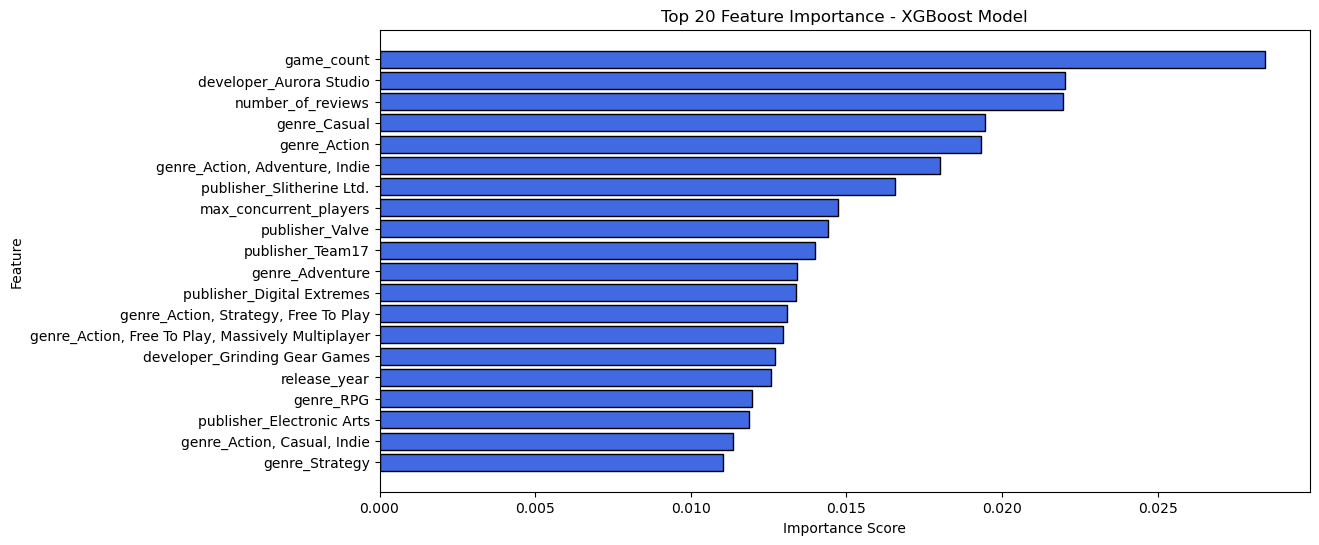

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature names and importance scores dynamically using sorted_indices_xgb
sorted_indices_xgb = np.argsort(feature_importance_xgb)[::-1]  # Sort in descending order

# Create a DataFrame for visualization
feature_importance_xgb_df = pd.DataFrame({
    "Feature": [feature_names_xgb[idx] for idx in sorted_indices_xgb],
    "Importance": [feature_importance_xgb[idx] for idx in sorted_indices_xgb]
})

# Plot Feature Importance for XGBoost
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_xgb_df["Feature"][:20], feature_importance_xgb_df["Importance"][:20], 
         color='royalblue', edgecolor='black')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [90]:
feature_importance_xgb_df[:10]

,Feature,Importance
0,game_count,0.028460
1,developer_Aurora Studio,0.022018
2,number_of_reviews,0.021947
3,genre_Casual,0.019471
4,genre_Action,0.019317
5,"genre_Action, Adventure, Indie",0.018006
6,publisher_Slitherine Ltd.,0.016553
7,max_concurrent_players,0.014739
8,publisher_Valve,0.014415
9,publisher_Team17,0.013994


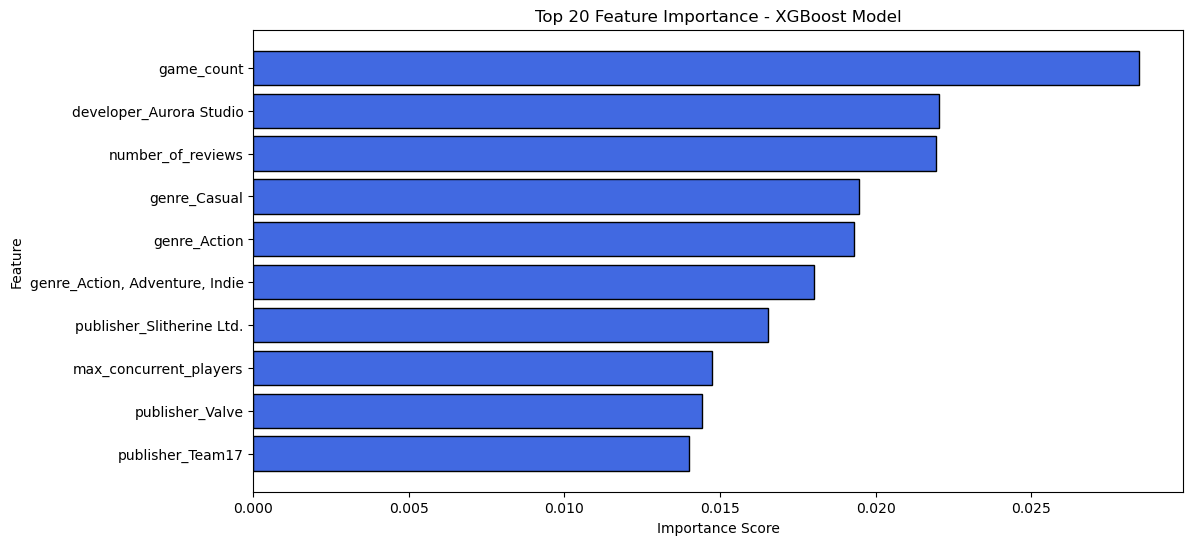

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature names and importance scores dynamically using sorted_indices_xgb
sorted_indices_xgb = np.argsort(feature_importance_xgb)[::-1]  # Sort in descending order

# Create a DataFrame for visualization
feature_importance_xgb_df = pd.DataFrame({
    "Feature": [feature_names_xgb[idx] for idx in sorted_indices_xgb],
    "Importance": [feature_importance_xgb[idx] for idx in sorted_indices_xgb]
})

# Plot Feature Importance for XGBoost
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_xgb_df["Feature"][:10], feature_importance_xgb_df["Importance"][:10], 
         color='royalblue', edgecolor='black')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
